In [1]:
import os 
import sys
import ismn
import pandas as pd
import numpy as np
import xarray as xr
from multiprocessing import Pool, cpu_count # 
from pathlib import Path
from datetime import datetime
import warnings
from ismn.interface import ISMN_Interface
import matplotlib.pyplot as plt

In [2]:
from utils import longest_available_after_removing_long_gaps,trim_to_surface_valid_period_and_keep_well_covered_depths,gapfill_by_monthday_mean_with_feb29_fallback

# This part is for preprocessing check

In [ ]:
insitu_dir = '/home/khanalp/data/ISMNsoilMoisture/'

In [ ]:
# Read the data using ISMN_Interface
ds = ISMN_Interface("/home/khanalp/data/ISMNsoilMoisture/Data_separate_files_header_20140101_20251231_13107_18mx_20260208", parallel=True)

In [ ]:
ds

In [ ]:
# 1. List networks and stations using modern ISMN interface
networks_stations = []
for network in ds.collection.networks:
    for station in ds.collection[network].stations:
        networks_stations.append({
            'network': network,
            'station': station
        })


In [ ]:
df_stations = pd.DataFrame(networks_stations)
print(f"Total stations: {len(df_stations)}")
df_stations

In [ ]:
# 2. Select one station to test (change these to your preferred station)
# test_network = df_stations.iloc[0]['network']  # First network
# test_station = df_stations.iloc[0]['station']  # First station
test_network = "PBO_H2O"
test_station = "MIDDLEGATE"

print(f"\n--- Testing with: {test_network} - {test_station} ---\n")
station_data = ds[test_network][test_station].to_xarray()
station_data  # To check how it looks like. 

In [ ]:
# Create output directory
output_dir = Path('processed_soil_moisture')
output_dir.mkdir(exist_ok=True)

In [ ]:
# Read station data
station_data = ds[network][station].to_xarray()

In [ ]:
mask = (station_data["soil_moisture_flag"] == "G") | station_data["soil_moisture_flag"].astype(str).str.startswith("D")

# Apply mask to soil_moisture
soil_moisture_masked = station_data['soil_moisture'].where(mask)

# Assign depth_from as a coordinate for grouping
soil_moisture_masked = soil_moisture_masked.assign_coords(
    depth_group=('sensor', station_data['depth_to'].values) # Use depth_to instead of depth_from because some stations have depth_from = 0 for all sensors, but depth_to varies and can be used to group sensors by depth.
)

In [ ]:
# Group by depth and average across sensors
depth_averaged = soil_moisture_masked.groupby('depth_group').mean(dim='sensor', skipna=True)
depth_averaged = depth_averaged.rename({'depth_group': 'depth'})

# Drop depths that have ALL NaN values (no valid data)
valid_count_per_depth = depth_averaged.count(dim='date_time')
depths_with_data = valid_count_per_depth > 0
depth_averaged = depth_averaged.where(depths_with_data, drop=True)

# # If no valid depths remain, return None
# if len(depth_averaged.depth) == 0:
#     return None

# Resample to daily
daily = depth_averaged.resample(date_time='1D').mean(dim='date_time', skipna=True)

# Count valid observations per day
count = depth_averaged.resample(date_time='1D').count(dim='date_time')

# Handle the casting more gracefully
try:
    count = count.fillna(0).astype(int)
except:
    count = count.astype(float)

# Mask out days with < 6 valid observations
daily_filtered = daily.where(count >= 6)

    # ---- depth-bin averaging AFTER daily filtering (no count saved) ----
depth_vals = daily_filtered["depth"].values.astype(float)
depth_cm = depth_vals * 100.0 if np.nanmax(depth_vals) <= 3 else depth_vals

depth_bin = pd.cut(
        depth_cm,
        bins=[0.0, 5.0, 20.0, 50.0, np.inf],
        labels=["0-5", "5-20", "20-50", ">50"],
        right=True,
        include_lowest=True
    )

daily_filtered = daily_filtered.assign_coords(depth_bin=("depth", depth_bin.astype(str)))

daily_binned = (
    daily_filtered.groupby("depth_bin")
    .mean(dim="depth", skipna=True)
    .rename({"depth_bin": "depth"})
)
# order = ["0-5", "5-20", "20-50", ">50"]
# daily_binned = daily_binned.reindex(depth=order)

result_ds = xr.Dataset({"soil_moisture": daily_binned})

# Add metadata as attributes
result_ds.attrs['network'] = network
result_ds.attrs['station'] = station
result_ds.attrs['latitude'] = float(station_data.attrs.get('lat', np.nan)) #The attrs lat and variables latitude are latitude.
result_ds.attrs['longitude'] = float(station_data.attrs.get('lon', np.nan)) # same for lon. 
result_ds.attrs["max_depth"] = float(np.nanmax(depth_vals))

In [ ]:
has_any_nan_values = result_ds["soil_moisture"].notnull().any().item()
has_any_nan_values 

In [ ]:
# Get metadata
lat = result_ds.attrs.get('latitude', np.nan)
lon = result_ds.attrs.get('longitude', np.nan)
depths = result_ds.depth.values.tolist()

# To remove long gaps greater than 7 days. 
longest_available = longest_available_after_removing_long_gaps(result_ds, max_gap_days=7) # dictionary with depth as key and longest available run (after removing long gaps) as value.

ds_clean = trim_to_surface_valid_period_and_keep_well_covered_depths(result_ds, longest_available, surface_depth="0-5", min_frac=0.95)

In [ ]:
longest_available

In [ ]:
ds_clean

In [ ]:
# Get date range
valid_dates = ds_clean['soil_moisture'].dropna(dim='date_time', how='all').date_time


ds_gap_filled = gapfill_by_monthday_mean_with_feb29_fallback(ds_clean)
    
# export ONLY if there are zero NaNs left
if ds_gap_filled['soil_moisture'].isnull().sum().values == 0:
    # ds_gap_filled.to_netcdf(filepath)
    print(f"Exported: {filepath}")
else:
    print(f"Skipped (still has NaNs): {filepath}")

    
start_date = pd.to_datetime(valid_dates.min().values).strftime('%Y%m%d')
end_date = pd.to_datetime(valid_dates.max().values).strftime('%Y%m%d')

# Create filename
filename = f"{network}_{station}_{start_date}_{end_date}.nc"
filepath = output_dir / filename

In [ ]:


da = result_ds["soil_moisture"]
# Ensure consistent dim order
if tuple(da.dims) != ("date_time", "depth"):
    da = da.transpose("date_time", "depth")

t = pd.to_datetime(da["date_time"].values)
depths = [str(d) for d in da["depth"].values]

plt.figure(figsize=(11, 5.5), dpi=150)
for i, d in enumerate(depths):
    y = da.sel(depth=da["depth"].values[i]).values
    plt.plot(t, y, linewidth=1.0, label=d)

plt.xlabel("Date")
plt.ylabel("Soil moisture")
plt.title("Soil moisture time series by depth")
plt.grid(True, linewidth=0.4, alpha=0.5)

# Legend handling (works for many depths)
plt.legend(title="Depth", ncol=2, fontsize=8, title_fontsize=9, frameon=False, loc="upper left", bbox_to_anchor=(1.02, 1.0))
plt.tight_layout()
plt.show()


In [ ]:
longest_avail = longest_available_after_removing_long_gaps(result_ds, max_gap_days=7)
longest_avail

In [ ]:
clean_ds = trim_to_surface_valid_period_and_keep_well_covered_depths(result_ds, longest_avail, surface_depth="0-5", min_frac=0.95)

In [ ]:


# -----------------------
# Make test data (daily, 2 depths, 2019-2021)
# -----------------------
t = pd.date_range("2019-01-01", "2021-12-31", freq="D")
depth = ["0-5", "5-20"]

vals = np.random.rand(len(depth), len(t)).astype("float32")

da = xr.DataArray(
    vals,
    dims=("depth", "date_time"),
    coords={"depth": depth, "date_time": t},
    name="soil_moisture",
)

# Inject NaN gaps
# depth 0-5:
#  - 2019: two gaps (5 days and 3 days)
#  - 2020: one gap (10 days)
#  - 2021: one gap (20 days) -> should be the longest overall for this depth
da.loc[dict(depth="0-5", date_time=slice("2019-02-01", "2019-02-05"))] = np.nan
da.loc[dict(depth="0-5", date_time=slice("2019-07-10", "2019-07-12"))] = np.nan
da.loc[dict(depth="0-5", date_time=slice("2020-03-01", "2020-03-10"))] = np.nan
da.loc[dict(depth="0-5", date_time=slice("2021-10-01", "2021-10-20"))] = np.nan

# depth 5-20:
#  - 2019: one gap (15 days) -> longest overall for this depth
#  - 2020: three gaps (2, 4, 1 days)
da.loc[dict(depth="5-20", date_time=slice("2019-11-01", "2019-11-15"))] = np.nan
da.loc[dict(depth="5-20", date_time=slice("2020-01-05", "2020-01-06"))] = np.nan
da.loc[dict(depth="5-20", date_time=slice("2020-06-10", "2020-06-13"))] = np.nan
da.loc[dict(depth="5-20", date_time=slice("2020-12-31", "2020-12-31"))] = np.nan

trial_ds = xr.Dataset({"soil_moisture": da})


In [ ]:
longest_avail = longest_available_after_removing_long_gaps(trial_ds, max_gap_days=7)

In [ ]:
longest_avail

In [ ]:
clean_ds = trim_to_surface_valid_period_and_keep_well_covered_depths(trial_ds, longest_avail, min_frac=0.95)

In [ ]:
clean_ds

In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# --- build the same trial dataset ---
t = pd.date_range("2019-01-01", "2021-12-31", freq="D")  # includes leap year 2020
depth = ["0-5", "5-20"]

rng = np.random.default_rng(0)
vals = rng.normal(loc=0.25, scale=0.05, size=(len(depth), len(t))).astype("float32")

da = xr.DataArray(
    vals,
    dims=("depth", "date_time"),
    coords={"depth": depth, "date_time": t},
    name="soil_moisture",
)

# Inject NaNs
da.loc[dict(depth="0-5", date_time=slice("2019-02-10", "2019-02-15"))] = np.nan
da.loc[dict(depth="0-5", date_time=slice("2020-02-10", "2020-02-12"))] = np.nan
da.loc[dict(depth="5-20", date_time=slice("2021-08-01", "2021-08-07"))] = np.nan
da.loc[dict(depth="0-5", date_time="2020-02-29")] = np.nan
da.loc[dict(depth="5-20", date_time="2020-02-29")] = np.nan

trial_ds = xr.Dataset({"soil_moisture": da})

# --- gap-fill with month-day mean + Feb-29 fallback (Feb-28 then Mar-01) ---
def gapfill_by_monthday_mean_with_feb29_fallback(
    ds: xr.Dataset,
    var: str = "soil_moisture",
    time_dim: str = "date_time",
):
    da = ds[var]
    orig_nan = da.isnull()

    md = da[time_dim].dt.strftime("%m-%d")
    clim = da.groupby(md).mean(time_dim, skipna=True)

    # Feb-29 fallback
    if "02-29" in clim[md.name].values:
        feb29 = clim.sel({md.name: "02-29"})
        if bool(feb29.isnull().all().item()):
            repl = clim.sel({md.name: "02-28"})
            if bool(repl.isnull().all().item()) and ("03-01" in clim[md.name].values):
                repl = repl.fillna(clim.sel({md.name: "03-01"}))
            clim.loc[{md.name: "02-29"}] = repl

    fill_vals = clim.sel({md.name: md})
    filled = da.where(~orig_nan, fill_vals)

    still_nan = filled.isnull()
    flag = xr.zeros_like(da, dtype=np.int8)
    flag = flag.where(orig_nan, other=0)
    flag = flag.where(~orig_nan, other=1)
    flag = flag.where(~still_nan, other=2)

    out = ds.copy()
    out[var] = filled
    out["gapfill_flag"] = flag
    return out

filled_ds = gapfill_by_monthday_mean_with_feb29_fallback(trial_ds)



In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

depth_sel = "0-5"

fill = filled_ds["soil_moisture"].sel(depth=depth_sel).to_series()
flag = filled_ds["gapfill_flag"].sel(depth=depth_sel).to_series()  # 1 = filled

plt.figure(figsize=(11, 5.5), dpi=200)

for y in sorted(fill.index.year.unique()):
    f = fill[fill.index.year == y]
    fl = flag[flag.index.year == y]

    # use a leap year so 02-29 is valid
    x = pd.to_datetime("2000-" + f.index.strftime("%m-%d"))

    plt.plot(x, f.values, linewidth=1.0, label=str(y))

    fi = fl.index[fl.values == 1]
    if len(fi) > 0:
        x_fi = pd.to_datetime("2000-" + fi.strftime("%m-%d"))
        plt.scatter(x_fi, f.loc[fi].values, s=18, marker="x")

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
plt.xlim(pd.Timestamp("2000-01-01"), pd.Timestamp("2000-12-31"))

plt.xlabel("Month")
plt.ylabel("Soil moisture")
plt.title(f"{depth_sel}: yearly series on Jan–Dec axis (x = gap-filled)")
plt.grid(True, linewidth=0.4, alpha=0.5)
plt.legend(title="Year", ncol=3, frameon=False, fontsize=8, title_fontsize=9)
plt.tight_layout()
plt.show()

To learn about ISMN data quality flag: check https://ismn.earth/en/data/flag-overview/
In short, G = good, D = Dubious, C= outside plausible range.

Inside process_station, \
1. Create a mask for good-quality measurements: soil_moisture_flag == "G".
2. Apply the mask to soil_moisture so non-G values become NaN.
3. Add a coordinate depth_group (per sensor) using depth_from so sensors can be grouped by depth.
4. Group by depth_group and take the mean across sensors (depth-average), ignoring NaNs.
5. Rename depth_group to depth.
6. Compute how many valid values each depth has over all times; drop depths that are all NaN.
7. If no depths remain, return None.
8. Resample to daily mean soil moisture (per depth).
9. Resample to a daily count of valid observations (per depth).
10.Try to convert the daily count to an integer (fallback to a float if conversion fails).
11. Mask daily soil moisture where the daily count is < 6 (those days become NaN).
12. Return an xarray.Dataset with:
13. soil_moisture (daily, filtered by count)
14. observation_count (daily count)
Add metadata attributes: network, station, latitude, and longitude.

In [ ]:
# Function to process each station
def process_station(station_data, network, station):
    """
    Process a single station dataset:
    - Depth average soil_moisture where flag = 'G'
    - Drop depths with no valid data
    - Convert to daily if >= 6 valid observations per day
    """
    # Create mask where soil_moisture_flag == "G" and also include "D" (Dubious) flags as valid data.
    # mask = station_data['soil_moisture_flag'] == "G"
    mask = (station_data["soil_moisture_flag"] == "G") | station_data["soil_moisture_flag"].astype(str).str.startswith("D")
    
    # Apply mask to soil_moisture
    soil_moisture_masked = station_data['soil_moisture'].where(mask)
    
    # Assign depth_from as a coordinate for grouping
    soil_moisture_masked = soil_moisture_masked.assign_coords(
        depth_group=('sensor', station_data['depth_to'].values) # Use depth_to instead of depth_from because some stations have depth_from = 0 for all sensors, but depth_to varies and can be used to group sensors by depth.
    )
    
    # Group by depth and average across sensors
    depth_averaged = soil_moisture_masked.groupby('depth_group').mean(dim='sensor', skipna=True)
    depth_averaged = depth_averaged.rename({'depth_group': 'depth'})
    
    # Drop depths that have ALL NaN values (no valid data)
    valid_count_per_depth = depth_averaged.count(dim='date_time')
    depths_with_data = valid_count_per_depth > 0
    depth_averaged = depth_averaged.where(depths_with_data, drop=True)
    
    # If no valid depths remain, return None
    if len(depth_averaged.depth) == 0:
        return None
    
    # Resample to daily
    daily = depth_averaged.resample(date_time='1D').mean(dim='date_time', skipna=True)
    
    # Count valid observations per day
    count = depth_averaged.resample(date_time='1D').count(dim='date_time')
    
    # Handle the casting more gracefully
    try:
        count = count.fillna(0).astype(int)
    except:
        count = count.astype(float)
    
    # Mask out days with < 6 valid observations
    daily_filtered = daily.where(count >= 6)
    
        # ---- depth-bin averaging AFTER daily filtering (no count saved) ----
    depth_vals = daily_filtered["depth"].values.astype(float)
    depth_cm = depth_vals * 100.0 if np.nanmax(depth_vals) <= 3 else depth_vals

    depth_bin = pd.cut(
        depth_cm,
        bins=[0.0, 5.0, 20.0, 50.0, np.inf],
        labels=["0-5", "5-20", "20-50", ">50"],
        right=True,
        include_lowest=True
    )

    daily_filtered = daily_filtered.assign_coords(depth_bin=("depth", depth_bin.astype(str)))

    daily_binned = (
        daily_filtered.groupby("depth_bin")
        .mean(dim="depth", skipna=True)
        .rename({"depth_bin": "depth"})
    )

    result_ds = xr.Dataset({"soil_moisture": daily_binned})
    
    # Add metadata as attributes
    result_ds.attrs['network'] = network
    result_ds.attrs['station'] = station
    result_ds.attrs['latitude'] = float(station_data.attrs.get('lat', np.nan)) #The attrs lat and variables latitude are latitude.
    result_ds.attrs['longitude'] = float(station_data.attrs.get('lon', np.nan)) # same for lon. 
    result_ds.attrs["max_depth"] = float(np.nanmax(depth_vals))
    return result_ds


## 'process_single_station' is just a wrapper for parallel processing. 
What really happens is:
1. station data is read into xarray. 
2. then process_station is called, which does QC, filtering, converts hourly to daily, which returns result_ds. 
3. If result_ds is None there we skip to other stations, if not
4. We get metadata like network, stations, longitude, latitude, depths, start_date, end_date, etc.
5. Filename is saved as f"{network}_{station}_{start_date}_{end_date}.nc" in output_dir.
6. Function returns metadata.


In [ ]:
def process_single_station(args):
    """
    Wrapper function for parallel processing
    """
    network, station, idx, total = args
    
    try:
        print(f"[{idx+1}/{total}] Processing: {network}/{station}")
        
        # Read station data
        station_data = ds[network][station].to_xarray()
        
        # Process station
        result_ds = process_station(station_data, network, station)
        
        # Skip if no valid data
        if result_ds is None:
            print(f"[{idx+1}/{total}] Skipped (no valid data): {network}/{station}")
            return None
        
        # Get metadata
        lat = result_ds.attrs.get('latitude', np.nan)
        lon = result_ds.attrs.get('longitude', np.nan)
        depths = result_ds.depth.values.tolist()
        
        # Get date range
        valid_dates = result_ds['soil_moisture'].dropna(dim='date_time', how='all').date_time
        if len(valid_dates) == 0:
            print(f"[{idx+1}/{total}] Skipped (no valid dates): {network}/{station}")
            return None
            
        start_date = pd.to_datetime(valid_dates.min().values).strftime('%Y%m%d')
        end_date = pd.to_datetime(valid_dates.max().values).strftime('%Y%m%d')
        
        # Create filename
        filename = f"{network}_{station}_{start_date}_{end_date}.nc"
        filepath = output_dir / filename
        
        # Save to netCDF
        result_ds.to_netcdf(filepath)
        
        print(f"[{idx+1}/{total}] Success: {network}/{station} -> {filename}")
        
        # Return metadata
        metadata = {
            'network': network,
            'station': station,
            'latitude': lat,
            'longitude': lon,
            'depths': str(depths),  # Convert list to string for CSV
            'n_depths': len(depths),
            'start_date': start_date,
            'end_date': end_date,
            'n_days': len(valid_dates),
            'filename': filename
        }
        
        return metadata
        
    except Exception as e:
        print(f"[{idx+1}/{total}] Error processing {network}/{station}: {e}")
        return None


In [ ]:
def process_single_station(args):
    """
    Wrapper function for parallel processing
    """
    network, station, idx, total = args
    
    try:
        print(f"[{idx+1}/{total}] Processing: {network}/{station}")
        
        # Read station data
        station_data = ds[network][station].to_xarray()
        
        # Process station
        result_ds = process_station(station_data, network, station)
        
        # Skip if no valid data
        if result_ds is None:
            print(f"[{idx+1}/{total}] Skipped (no valid data): {network}/{station}")
            return None
        
        # Get metadata
        lat = result_ds.attrs.get('latitude', np.nan)
        lon = result_ds.attrs.get('longitude', np.nan)
        depths = result_ds.depth.values.tolist()
        
        # Get date range
        valid_dates = result_ds['soil_moisture'].dropna(dim='date_time', how='all').date_time
        if len(valid_dates) == 0:
            print(f"[{idx+1}/{total}] Skipped (no valid dates): {network}/{station}")
            return None
            
        start_date = pd.to_datetime(valid_dates.min().values).strftime('%Y%m%d')
        end_date = pd.to_datetime(valid_dates.max().values).strftime('%Y%m%d')
        
        # Create filename
        filename = f"{network}_{station}_{start_date}_{end_date}.nc"
        filepath = output_dir / filename
        
        # Save to netCDF
        result_ds.to_netcdf(filepath)
        
        print(f"[{idx+1}/{total}] Success: {network}/{station} -> {filename}")
        
        # Return metadata
        metadata = {
            'network': network,
            'station': station,
            'latitude': lat,
            'longitude': lon,
            # 'depths': str(depths),  # Convert list to string for CSV
            # 'n_depths': len(depths),
            'max_depth (cm)': result_ds.attrs.get("max_depth", np.nan) * 100.0,  # Convert to cm
            'start_date': start_date,
            'end_date': end_date,
            'n_days': len(valid_dates),
            'filename': filename
        }
        
        return metadata
        
    except Exception as e:
        print(f"[{idx+1}/{total}] Error processing {network}/{station}: {e}")
        return None


In [ ]:
# # Inspect the data structure
# print("Data structure:")
# print(ds_test)
# print("\n" + "="*60 + "\n")

# # Check dimensions
# print("Dimensions:")
# print(ds_test.dims)
# print("\n" + "="*60 + "\n")

# # Check coordinates
# print("Coordinates:")
# print(ds_test.coords)
# print("\n" + "="*60 + "\n")


In [ ]:
# Collect all station tasks
all_tasks = []
for network in ds.collection.networks:
    for station in ds.collection[network].stations:
        all_tasks.append((network, station))

In [ ]:

# ============================================
# CONFIGURE TEST RUN HERE
# ============================================
TEST_MODE = True  # Set to False to process all stations
N_TEST_STATIONS = 1  # Number of stations to test with

if TEST_MODE:
    tasks = all_tasks[:N_TEST_STATIONS]
    print(f"=== TEST MODE: Processing {N_TEST_STATIONS} stations ===")
else:
    tasks = all_tasks
    print(f"=== FULL MODE: Processing all {len(tasks)} stations ===")

# Add index and total count to tasks
tasks_with_idx = [(net, sta, i, len(tasks)) for i, (net, sta) in enumerate(tasks)]

print(f"Output directory: {output_dir}/")
print(f"Using {cpu_count()} CPU cores available")

In [ ]:

# ============================================
# CONFIGURE PARALLELIZATION HERE
# ============================================
USE_PARALLEL = False  # Set to False for sequential (easier debugging)
N_WORKERS = 10  # Number of parallel workers (adjust as needed)

if USE_PARALLEL:
    print(f"Running in parallel with {N_WORKERS} workers")
    with Pool(N_WORKERS) as pool:
        results = pool.map(process_single_station, tasks_with_idx)
else:
    print("Running sequentially (no parallelization)")
    results = [process_single_station(task) for task in tasks_with_idx]

In [ ]:

# Filter out None results
metadata_list = [r for r in results if r is not None]

# Create metadata DataFrame
if len(metadata_list) > 0:
    df_metadata = pd.DataFrame(metadata_list)
    
    print(f"\n{'='*60}")
    print(f"Processing complete!")
    print(f"Successfully processed: {len(df_metadata)}/{len(tasks)} stations")
    print(f"Files saved to: {output_dir}/")
    print(f"\nMetadata summary:")
    print(df_metadata.head(20))
    
    # Save metadata
    metadata_file = output_dir / 'station_metadata.csv'
    df_metadata.to_csv(metadata_file, index=False)
    print(f"\nMetadata saved to: {metadata_file}")
    
    # Print summary statistics
    print(f"\nSummary:")
    print(f"  Networks: {df_metadata['network'].nunique()}")
    print(f"  Stations: {len(df_metadata)}")
    print(f"  Date range: {df_metadata['start_date'].min()} to {df_metadata['end_date'].max()}")
    print(f"  Depth range: {df_metadata['n_depths'].min()}-{df_metadata['n_depths'].max()} depths per station")
    
else:
    print("\nNo valid data found across all stations")

In [ ]:
df_metadata = pd.read_csv('/home/khanalp/code/PhD/soilMoisture/processed_soil_moisture/station_metadata.csv')

In [ ]:
df_metadata

In [ ]:
output_dir = "/home/khanalp/code/PhD/soilMoisture/processed_soil_moisture/"
# Create directory for plot 
plot_dir = "/home/khanalp/code/PhD/soilMoisture/processed_soil_moisture/plots_for_gap_filled/"
plot_dir = Path(plot_dir)
plot_dir.mkdir(exist_ok=True)

In [ ]:
nc_files = list(Path(output_dir).glob("*.nc"))
len(nc_files)

# Plotting check

In [3]:
# ---------------- Plot style (your template) ----------------
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots  # registers 'science', 'no-latex', etc.


plt.style.use(['science', 'no-latex'])
mpl.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'Times', 'DejaVu Serif'],
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.titleweight': 'bold',
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'lines.linewidth': 2,
    'legend.fontsize': 12,
    'figure.dpi': 300,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 6,
    'ytick.major.size': 6,
    'xtick.minor.size': 3,
    'ytick.minor.size': 3,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
})


In [ ]:
# Add index + total (same pattern as your station processing)
nc_files_with_idx = [(str(f), str(plot_dir), i, len(nc_files)) for i, f in enumerate(nc_files)]

In [ ]:
USE_PARALLEL = True   # False = sequential (easier debugging)
N_WORKERS = 50        # adjust as needed

In [ ]:
def plot_single_file(task):
    f, plot_dir, i, total = task
    try:
        ds = xr.open_dataset(f)

        if "soil_moisture" not in ds.data_vars:
            ds.close()
            return None

        station = ds.attrs.get("station", Path(f).stem)
        network = ds.attrs.get("network", "")
        title = f"Soil Moisture - {station}" + (f" ({network})" if network else "")

        fig, ax = plt.subplots(figsize=(14, 6))

        if ("depth" in ds.dims) or ("depth" in ds.coords):
            for depth in ds["depth"].values:
                ds["soil_moisture"].sel(depth=depth).plot(ax=ax, label=str(depth))
            ax.legend(title="Depth")
        else:
            ds["soil_moisture"].plot(ax=ax, label="soil_moisture")
            ax.legend()

        ax.set_ylabel("Soil Moisture")
        ax.set_xlabel("Date")
        ax.set_title(title)
        ax.grid(True, alpha=0.3)
        plt.tight_layout()

        out_png = Path(plot_dir) / f"{Path(f).stem}_soil_moisture_by_depth.png"
        plt.savefig(out_png, dpi=300, bbox_inches="tight")
        plt.close(fig)
        ds.close()

        if (i + 1) % 50 == 0:
            print(f"[{i+1}/{total}] done")

        return str(out_png)

    except Exception as e:
        return f"FAILED: {f} -> {e}"

In [ ]:
if USE_PARALLEL:
    print(f"Running in parallel with {N_WORKERS} workers")
    with Pool(N_WORKERS) as pool:
        results = pool.map(plot_single_file, nc_files_with_idx)
else:
    print("Running sequentially (no parallelization)")
    results = [plot_single_file(task) for task in nc_files_with_idx]

# Optional: quick summary
n_ok = sum(r is not None and not str(r).startswith("FAILED:") for r in results)
n_fail = sum(isinstance(r, str) and r.startswith("FAILED:") for r in results)
print(f"Saved {n_ok} plots, failed {n_fail}. Output: {plot_dir}")

# Metadata Analysis

In [51]:
df_metadata = pd.read_csv("/home/khanalp/data/soilmoisture/level1/station_metadata.csv")
df_metadata_selected = df_metadata[df_metadata["status"] == "saved" ]

In [57]:
plot_output_path = "/home/khanalp/code/PhD/soilMoisture/plots/"

In [52]:
df_metadata.status.unique()

array(['saved', 'skipped'], dtype=object)

In [53]:
depth_labels = ["0-10", "10-30", "30-50", ">50"]

depth_counts = pd.Series(
    {depth: df_metadata_selected["depths"].str.contains(depth, regex=False).sum()
     for depth in depth_labels},
    name="n_stations"
)
print(depth_counts)

0-10     1319
10-30    1006
30-50     300
>50       713
Name: n_stations, dtype: int64


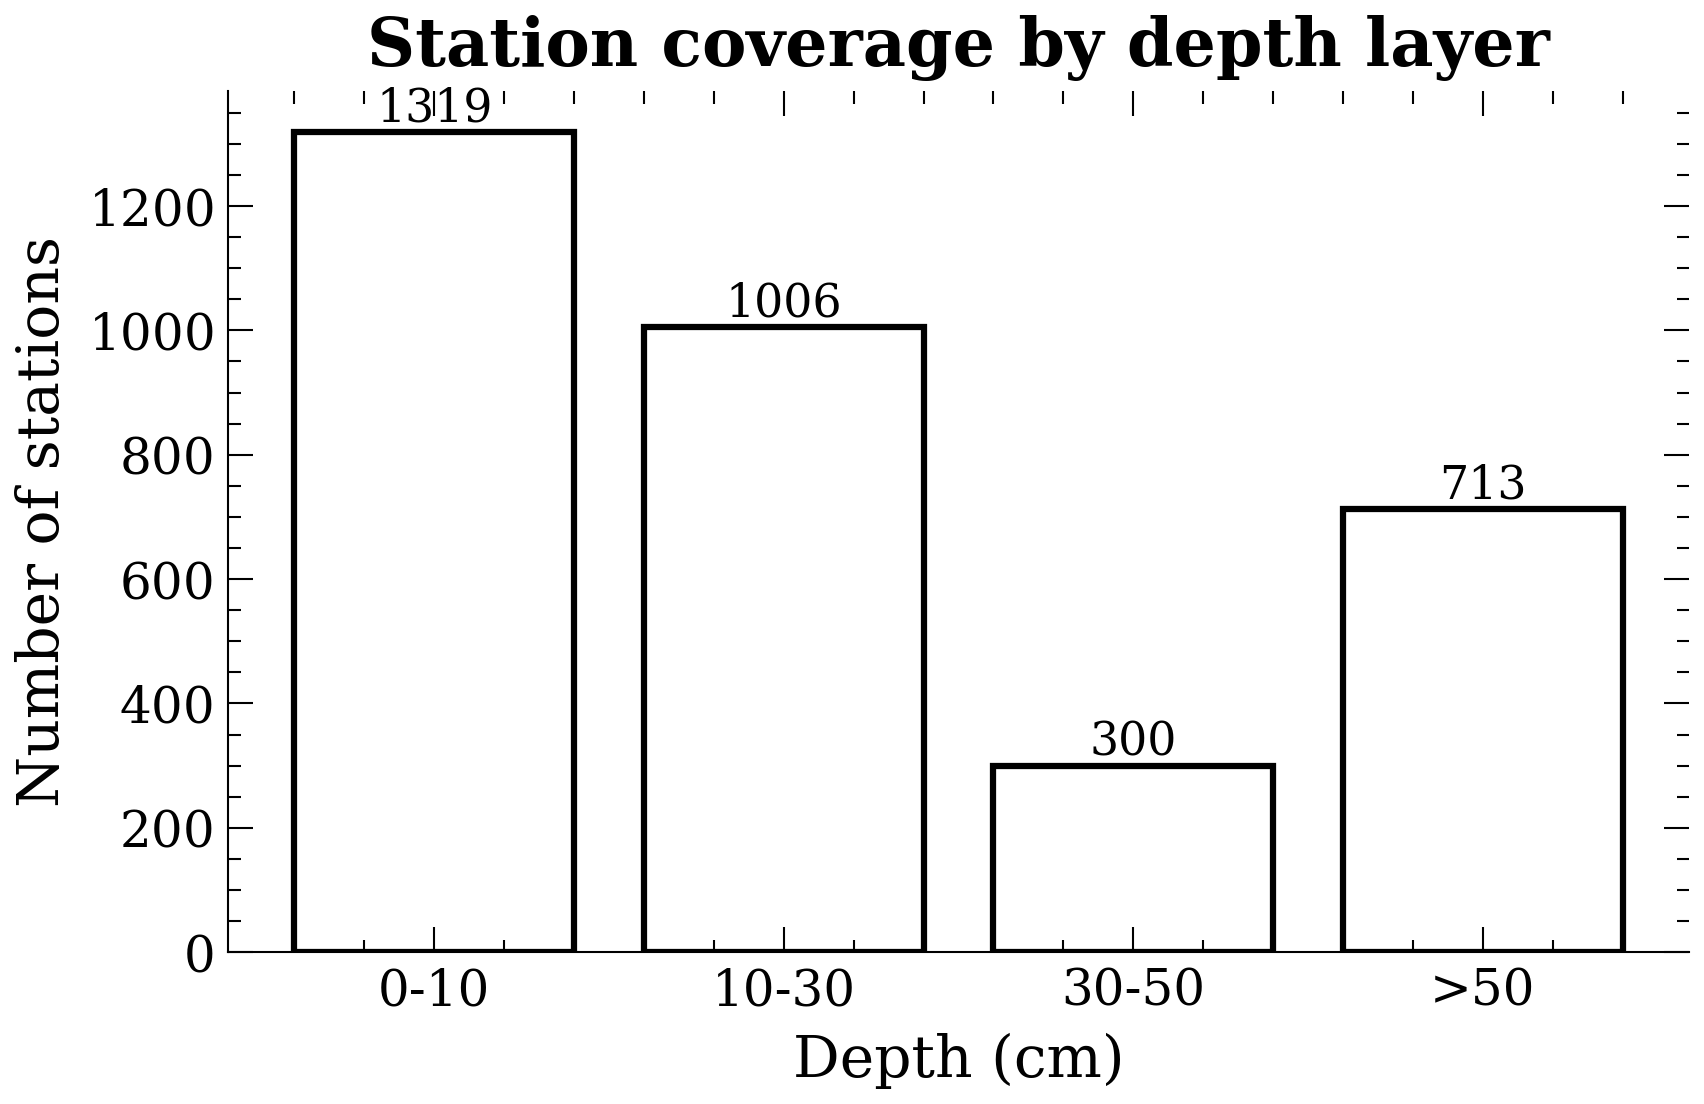

In [59]:
fig, ax = plt.subplots(figsize=(6, 4))

bars = ax.bar(depth_counts.index, depth_counts.values,
              color="none", edgecolor="black", linewidth=1.5)

for bar, val in zip(bars, depth_counts.values):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,
            str(val), ha="center", va="bottom", fontsize=11, color="black")

ax.set_xlabel("Depth (cm)")
ax.set_ylabel("Number of stations")
ax.set_title("Station coverage by depth layer")
plt.savefig(f"{plot_output_path}stations_by_depth.svg", format="svg", bbox_inches="tight")
plt.tight_layout()
plt.show()

In [8]:

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.ticker import MultipleLocator


/home/khanalp/.local/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


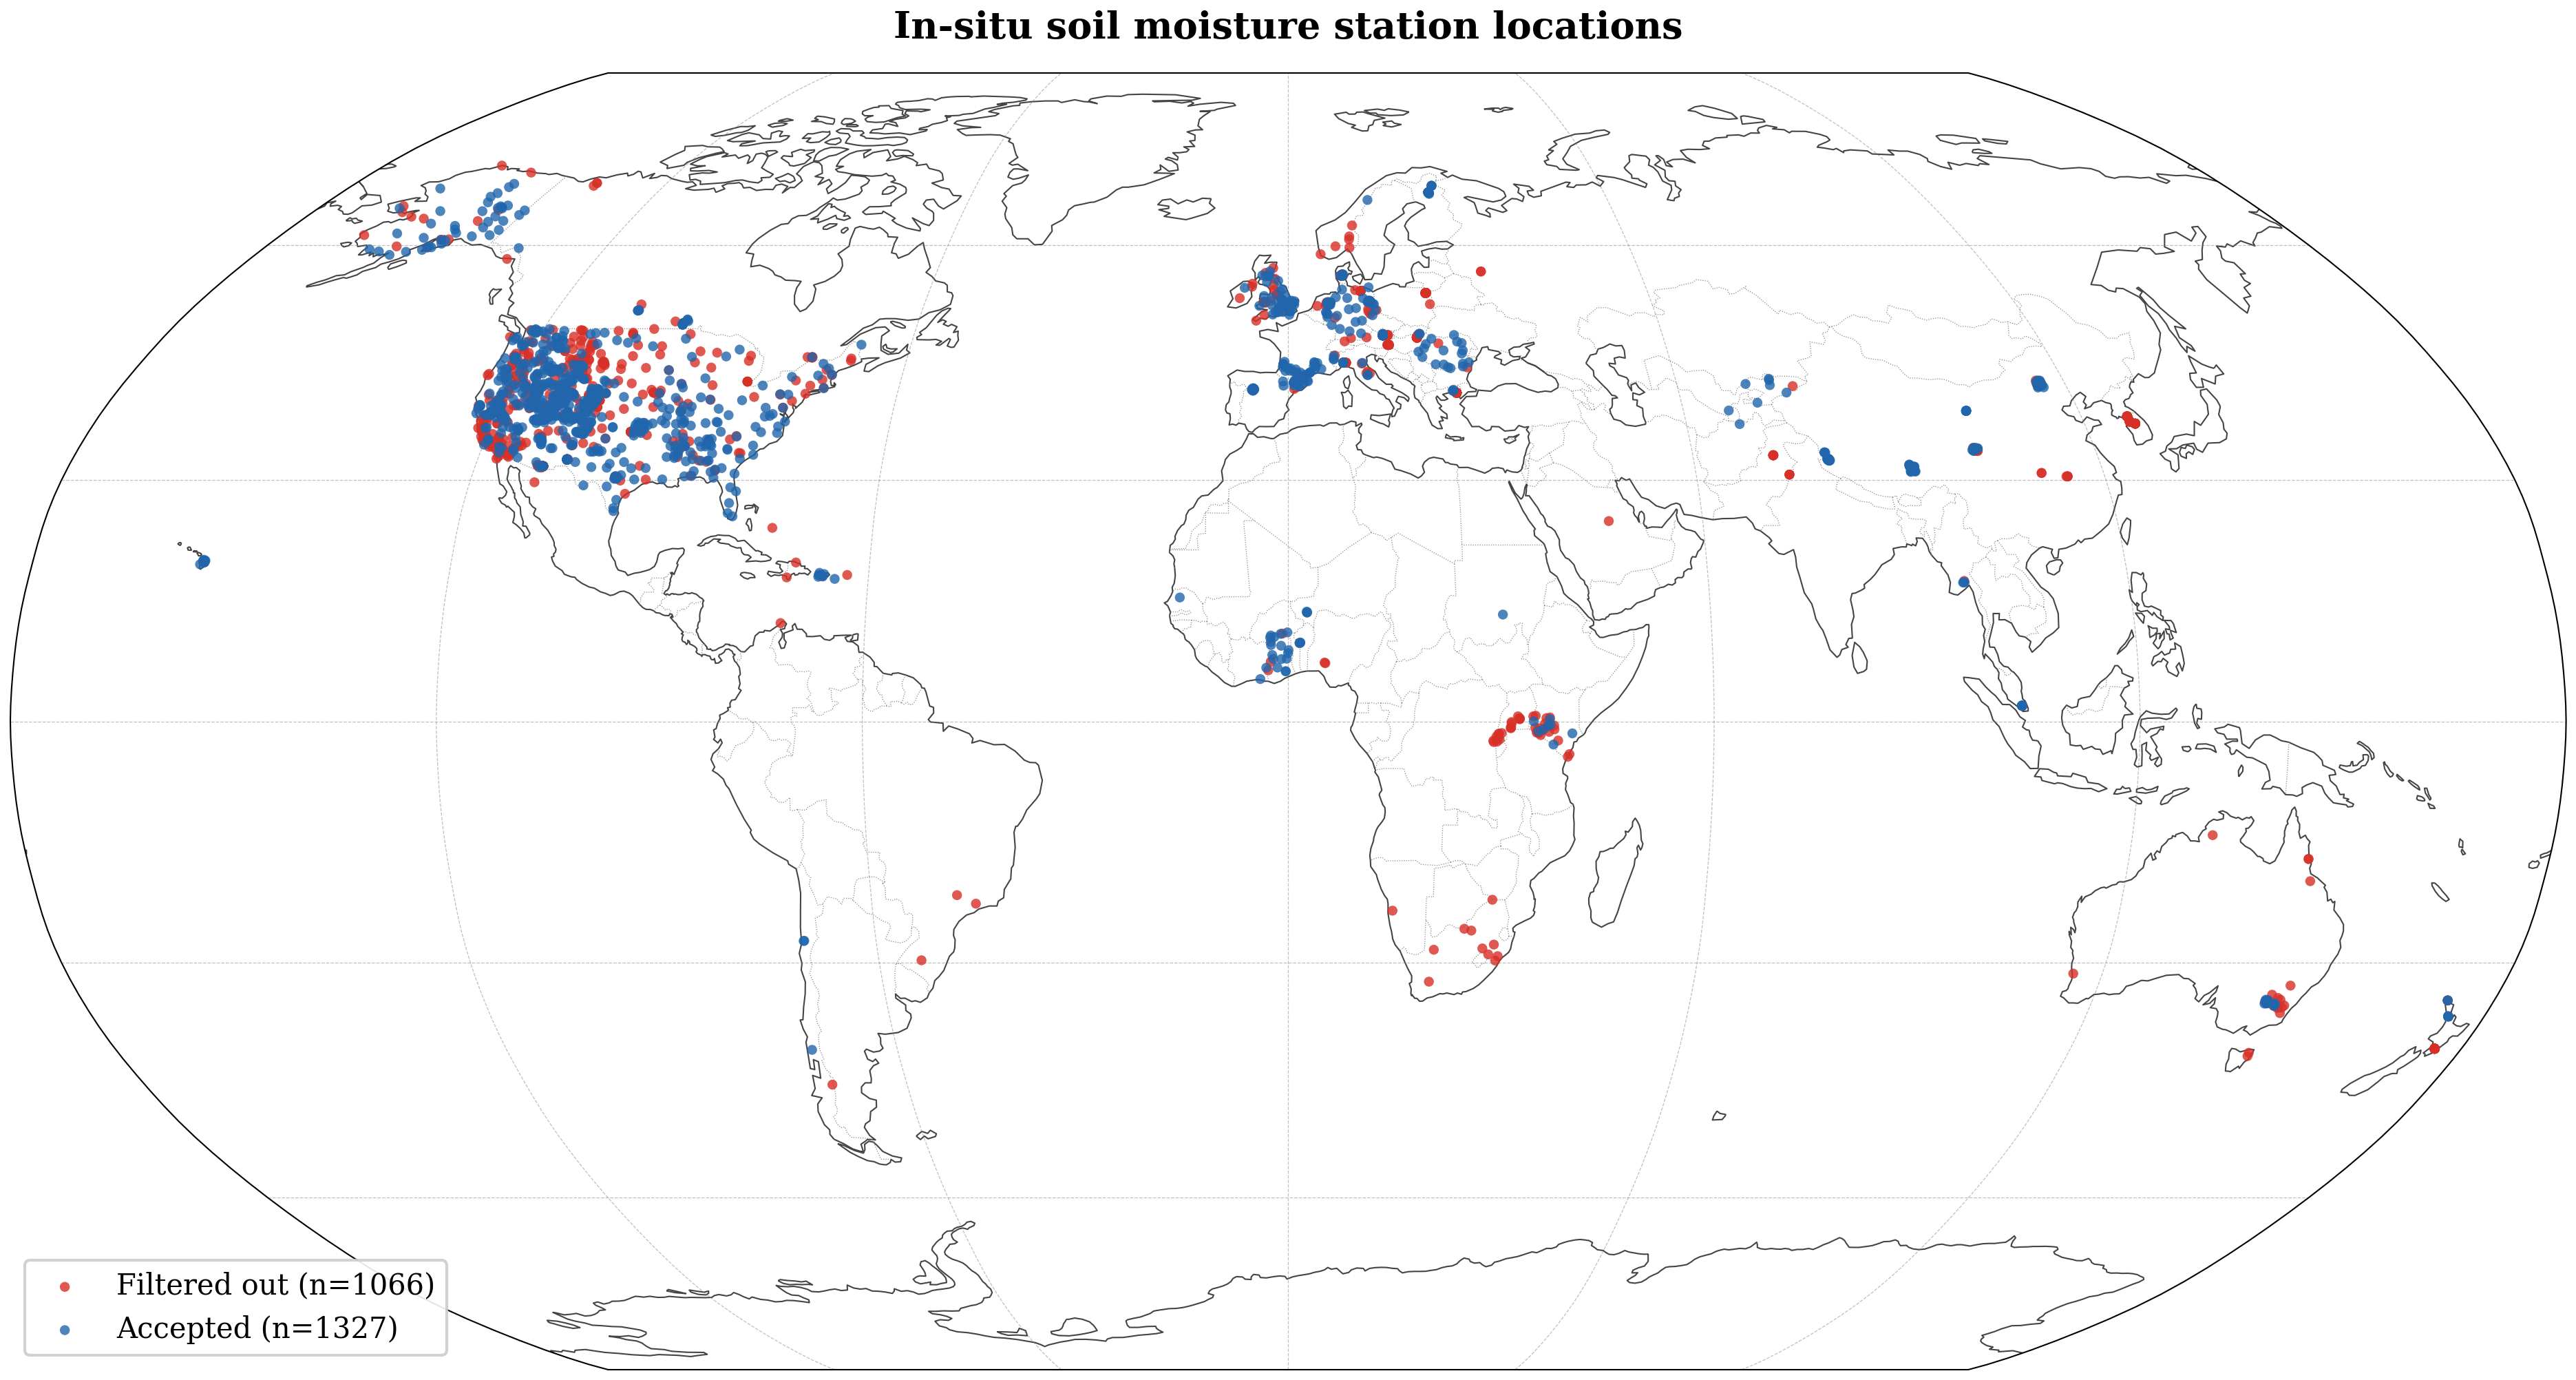

In [60]:
color_map = {"saved": "#2166ac", "skipped": "#d73027"}
label_map = {"saved": f"Accepted (n={( df_metadata['status']=='saved').sum()})",
             "skipped": f"Filtered out (n={(df_metadata['status']=='skipped').sum()})"}

fig, ax = plt.subplots(figsize=(14, 7),
                       subplot_kw={"projection": ccrs.Robinson()})

ax.set_global()
ax.set_facecolor("white")
ax.add_feature(cfeature.LAND,      facecolor="none",    edgecolor="none")
ax.add_feature(cfeature.OCEAN,     facecolor="none",    edgecolor="none")
ax.add_feature(cfeature.COASTLINE, linewidth=0.5,       color="#444444")
ax.add_feature(cfeature.BORDERS,   linewidth=0.3,       color="#888888", linestyle=":")
ax.add_feature(cfeature.LAKES,     facecolor="none",    edgecolor="none")
ax.gridlines(draw_labels=False, linewidth=0.3, color="gray", alpha=0.5, linestyle="--")

# plot skipped first so accepted renders on top
for status in ["skipped", "saved"]:
    sub = df_metadata[df_metadata["status"] == status]
    ax.scatter(
        sub["longitude"], sub["latitude"],
        transform=ccrs.PlateCarree(),
        s=12, color=color_map[status],
        edgecolors="none", alpha=0.8,
        zorder=5 if status == "skipped" else 6,
        label=label_map[status]
    )

ax.legend(loc="lower left", fontsize=10, frameon=True,
          framealpha=0.9, edgecolor="#cccccc")
ax.set_title("In-situ soil moisture station locations",
             fontsize=13, fontweight="bold", pad=12)

plt.tight_layout()
plt.savefig(f"{plot_output_path}stations_map_status.svg", format="svg", bbox_inches="tight")
plt.show()

In [67]:
from osgeo import gdal

hdf_file = gdal.Open("/home/khanalp/data/IGBP/MCD12C1.A2020001.061.2022172062638.hdf")

# list all subdatasets (each land cover type is a separate layer)
for name, desc in hdf_file.GetSubDatasets():
    print(name)
    print(desc)
    print()

HDF4_EOS:EOS_GRID:"/home/khanalp/data/IGBP/MCD12C1.A2020001.061.2022172062638.hdf":MOD12C1:Majority_Land_Cover_Type_1
[3600x7200] Majority_Land_Cover_Type_1 MOD12C1 (8-bit unsigned integer)

HDF4_EOS:EOS_GRID:"/home/khanalp/data/IGBP/MCD12C1.A2020001.061.2022172062638.hdf":MOD12C1:Majority_Land_Cover_Type_1_Assessment
[3600x7200] Majority_Land_Cover_Type_1_Assessment MOD12C1 (8-bit unsigned integer)

HDF4_EOS:EOS_GRID:"/home/khanalp/data/IGBP/MCD12C1.A2020001.061.2022172062638.hdf":MOD12C1:Land_Cover_Type_1_Percent
[3600x7200x17] Land_Cover_Type_1_Percent MOD12C1 (8-bit unsigned integer)

HDF4_EOS:EOS_GRID:"/home/khanalp/data/IGBP/MCD12C1.A2020001.061.2022172062638.hdf":MOD12C1:Majority_Land_Cover_Type_2
[3600x7200] Majority_Land_Cover_Type_2 MOD12C1 (8-bit unsigned integer)

HDF4_EOS:EOS_GRID:"/home/khanalp/data/IGBP/MCD12C1.A2020001.061.2022172062638.hdf":MOD12C1:Majority_Land_Cover_Type_2_Assessment
[3600x7200] Majority_Land_Cover_Type_2_Assessment MOD12C1 (8-bit unsigned integer)



In [68]:
subdataset = 'HDF4_EOS:EOS_GRID:"/home/khanalp/data/IGBP/MCD12C1.A2020001.061.2022172062638.hdf":MOD12C1:Majority_Land_Cover_Type_1'

ds = gdal.Open(subdataset)
print(ds)  # should not be None

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f26dc809730> >


In [69]:
igbp_array = ds.ReadAsArray()   # numpy array (3600, 7200)

In [70]:
igbp_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [71]:
# get geotransform to convert lat/lon -> row/col
gt = ds.GetGeoTransform() # gt = (xmin, xres, 0, ymax, 0, -yres)
gt

(-180.0, 0.05, 0.0, 90.0, 0.0, -0.05)

In [72]:

def latlon_to_rowcol(lat, lon, gt):
    col = int((lon - gt[0]) / gt[1]) # how many pixel from left edge
    row = int((lat - gt[3]) / gt[5]) # how many pixel from top edge
    return row, col

In [73]:
def sample_igbp(lat, lon):
    try:
        row, col = latlon_to_rowcol(lat, lon, gt)
        if 0 <= row < igbp_array.shape[0] and 0 <= col < igbp_array.shape[1]:
            return int(igbp_array[row, col])
        return np.nan
    except Exception:
        return np.nan

In [74]:
df_metadata["igbp_code"] = df_metadata.apply(
    lambda row: sample_igbp(row["latitude"], row["longitude"]), axis=1
)

In [75]:
df_metadata

network                  station status remark  latitude  longitude  \
0     AMMA-CATCH              Banizoumbou  saved    NaN  13.53250    2.66040   
1     AMMA-CATCH          Belefoungou-Mid  saved    NaN   9.79506    1.70994   
2     AMMA-CATCH          Belefoungou-Top  saved    NaN   9.78986    1.70994   
3     AMMA-CATCH              Nalohou-Mid  saved    NaN   9.74530    1.60530   
4     AMMA-CATCH              Nalohou-Top  saved    NaN   9.74407    1.60580   
...          ...                      ...    ...    ...       ...        ...   
2388        iRON      NorthstarAspenGrove  saved    NaN  39.17067 -106.79944   
2389        iRON  NorthstarTransitionZone  saved    NaN  39.17114 -106.79917   
2390        iRON              SkyMountain  saved    NaN  39.22098 -106.91313   
2391        iRON         SmugglerMountain  saved    NaN  39.20015 -106.80083   
2392        iRON             SpringValley  saved    NaN  39.47217 -107.22222   

      start_date    end_date  n_days  max_depth_cm  \
0     20140101.0  20181230.0  1823.0           5.0   
1     20140101.0  20171109.0  1399.0         100.0   
2     20141213.0  20171230.0  1114.0         100.0   
3     20151110.0  20170603.0   566.0          40.0   
4     20150310.0  20161118.0   617.0         100.0   
...          ...         ...     ...           ...   
2388  20150912.0  20210705.0  2120.0          50.0   
2389  20200504.0  20250924.0  1948.0          50.0   
2390  20140101.0  20220607.0  3080.0          50.0   
2391  20220830.0  20250213.0   899.0          50.0   
2392  20231231.0  20250924.0   632.0          50.0   

                                 depths  \
0                              ['0-10']   
1     ['0-10', '10-30', '30-50', '>50']   
2                              ['0-10']   
3            ['0-10', '10-30', '30-50']   
4                     ['0-10', '10-30']   
...                                 ...   
2388         ['0-10', '10-30', '30-50']   
2389                           ['0-10']   
2390         ['0-10', '10-30', '30-50']   
2391         ['0-10', '10-30', '30-50']   
2392         ['0-10', '10-30', '30-50']   

                                               filename  \
0           AMMA-CATCH_Banizoumbou_20140101_20181230.nc   
1       AMMA-CATCH_Belefoungou-Mid_20140101_20171109.nc   
2       AMMA-CATCH_Belefoungou-Top_20141213_20171230.nc   
3           AMMA-CATCH_Nalohou-Mid_20151110_20170603.nc   
4           AMMA-CATCH_Nalohou-Top_20150310_20161118.nc   
...                                                 ...   
2388      iRON_NorthstarAspenGrove_20150912_20210705.nc   
2389  iRON_NorthstarTransitionZone_20200504_20250924.nc   
2390              iRON_SkyMountain_20140101_20220607.nc   
2391         iRON_SmugglerMountain_20220830_20250213.nc   
2392             iRON_SpringValley_20231231_20250924.nc   

                                               filepath  igbp_code  
0     /home/khanalp/data/soilmoisture/level1/AMMA-CA...       10.0  
1     /home/khanalp/data/soilmoisture/level1/AMMA-CA...       12.0  
2     /home/khanalp/data/soilmoisture/level1/AMMA-CA...       12.0  
3     /home/khanalp/data/soilmoisture/level1/AMMA-CA...       12.0  
4     /home/khanalp/data/soilmoisture/level1/AMMA-CA...       12.0  
...                                                 ...        ...  
2388  /home/khanalp/data/soilmoisture/level1/iRON_No...        8.0  
2389  /home/khanalp/data/soilmoisture/level1/iRON_No...        8.0  
2390  /home/khanalp/data/soilmoisture/level1/iRON_Sk...        9.0  
2391  /home/khanalp/data/soilmoisture/level1/iRON_Sm...        9.0  
2392  /home/khanalp/data/soilmoisture/level1/iRON_Sp...       10.0  

[2393 rows x 14 columns]

In [76]:
igbp_classes = {
    1:   ("Evergreen Needleleaf Forests",        "ENF"),
    2:   ("Evergreen Broadleaf Forests",          "EBF"),
    3:   ("Deciduous Needleleaf Forests",         "DNF"),
    4:   ("Deciduous Broadleaf Forests",          "DBF"),
    5:   ("Mixed Forests",                        "MF"),
    6:   ("Closed Shrublands",                    "CSH"),
    7:   ("Open Shrublands",                      "OSH"),
    8:   ("Woody Savannas",                       "WSA"),
    9:   ("Savannas",                             "SAV"),
    10:  ("Grasslands",                           "GRA"),
    11:  ("Permanent Wetlands",                   "WET"),
    12:  ("Croplands",                            "CRO"),
    13:  ("Urban and Built-up Lands",             "URB"),
    14:  ("Cropland/Natural Vegetation Mosaics",  "CVM"),
    15:  ("Permanent Snow and Ice",               "SNW"),
    16:  ("Barren",                               "BAR"),
    17:  ("Water Bodies",                         "WAT"),
    255: ("Unclassified",                         "UNC"),
}



In [77]:
df_metadata["igbp_land_cover"] = df_metadata["igbp_code"].map(lambda x: igbp_classes.get(x, (None, None))[0])
df_metadata["igbp_short"]      = df_metadata["igbp_code"].map(lambda x: igbp_classes.get(x, (None, None))[1])

In [78]:
counts = (
    df_metadata[df_metadata["status"] == "saved"]
    .groupby("igbp_short")
    .size()
    .sort_values(ascending=False)
    .reset_index(name="n_stations")   # <-- this converts to DataFrame
)
print(counts)

   igbp_short  n_stations
0         GRA         571
1         CRO         195
2         SAV         195
3         WSA         136
4         ENF          45
5         BAR          40
6         OSH          36
7         URB          34
8         CVM          20
9         DBF          17
10         MF          16
11        EBF          12
12        CSH           2
13        SNW           1
14        WET           1


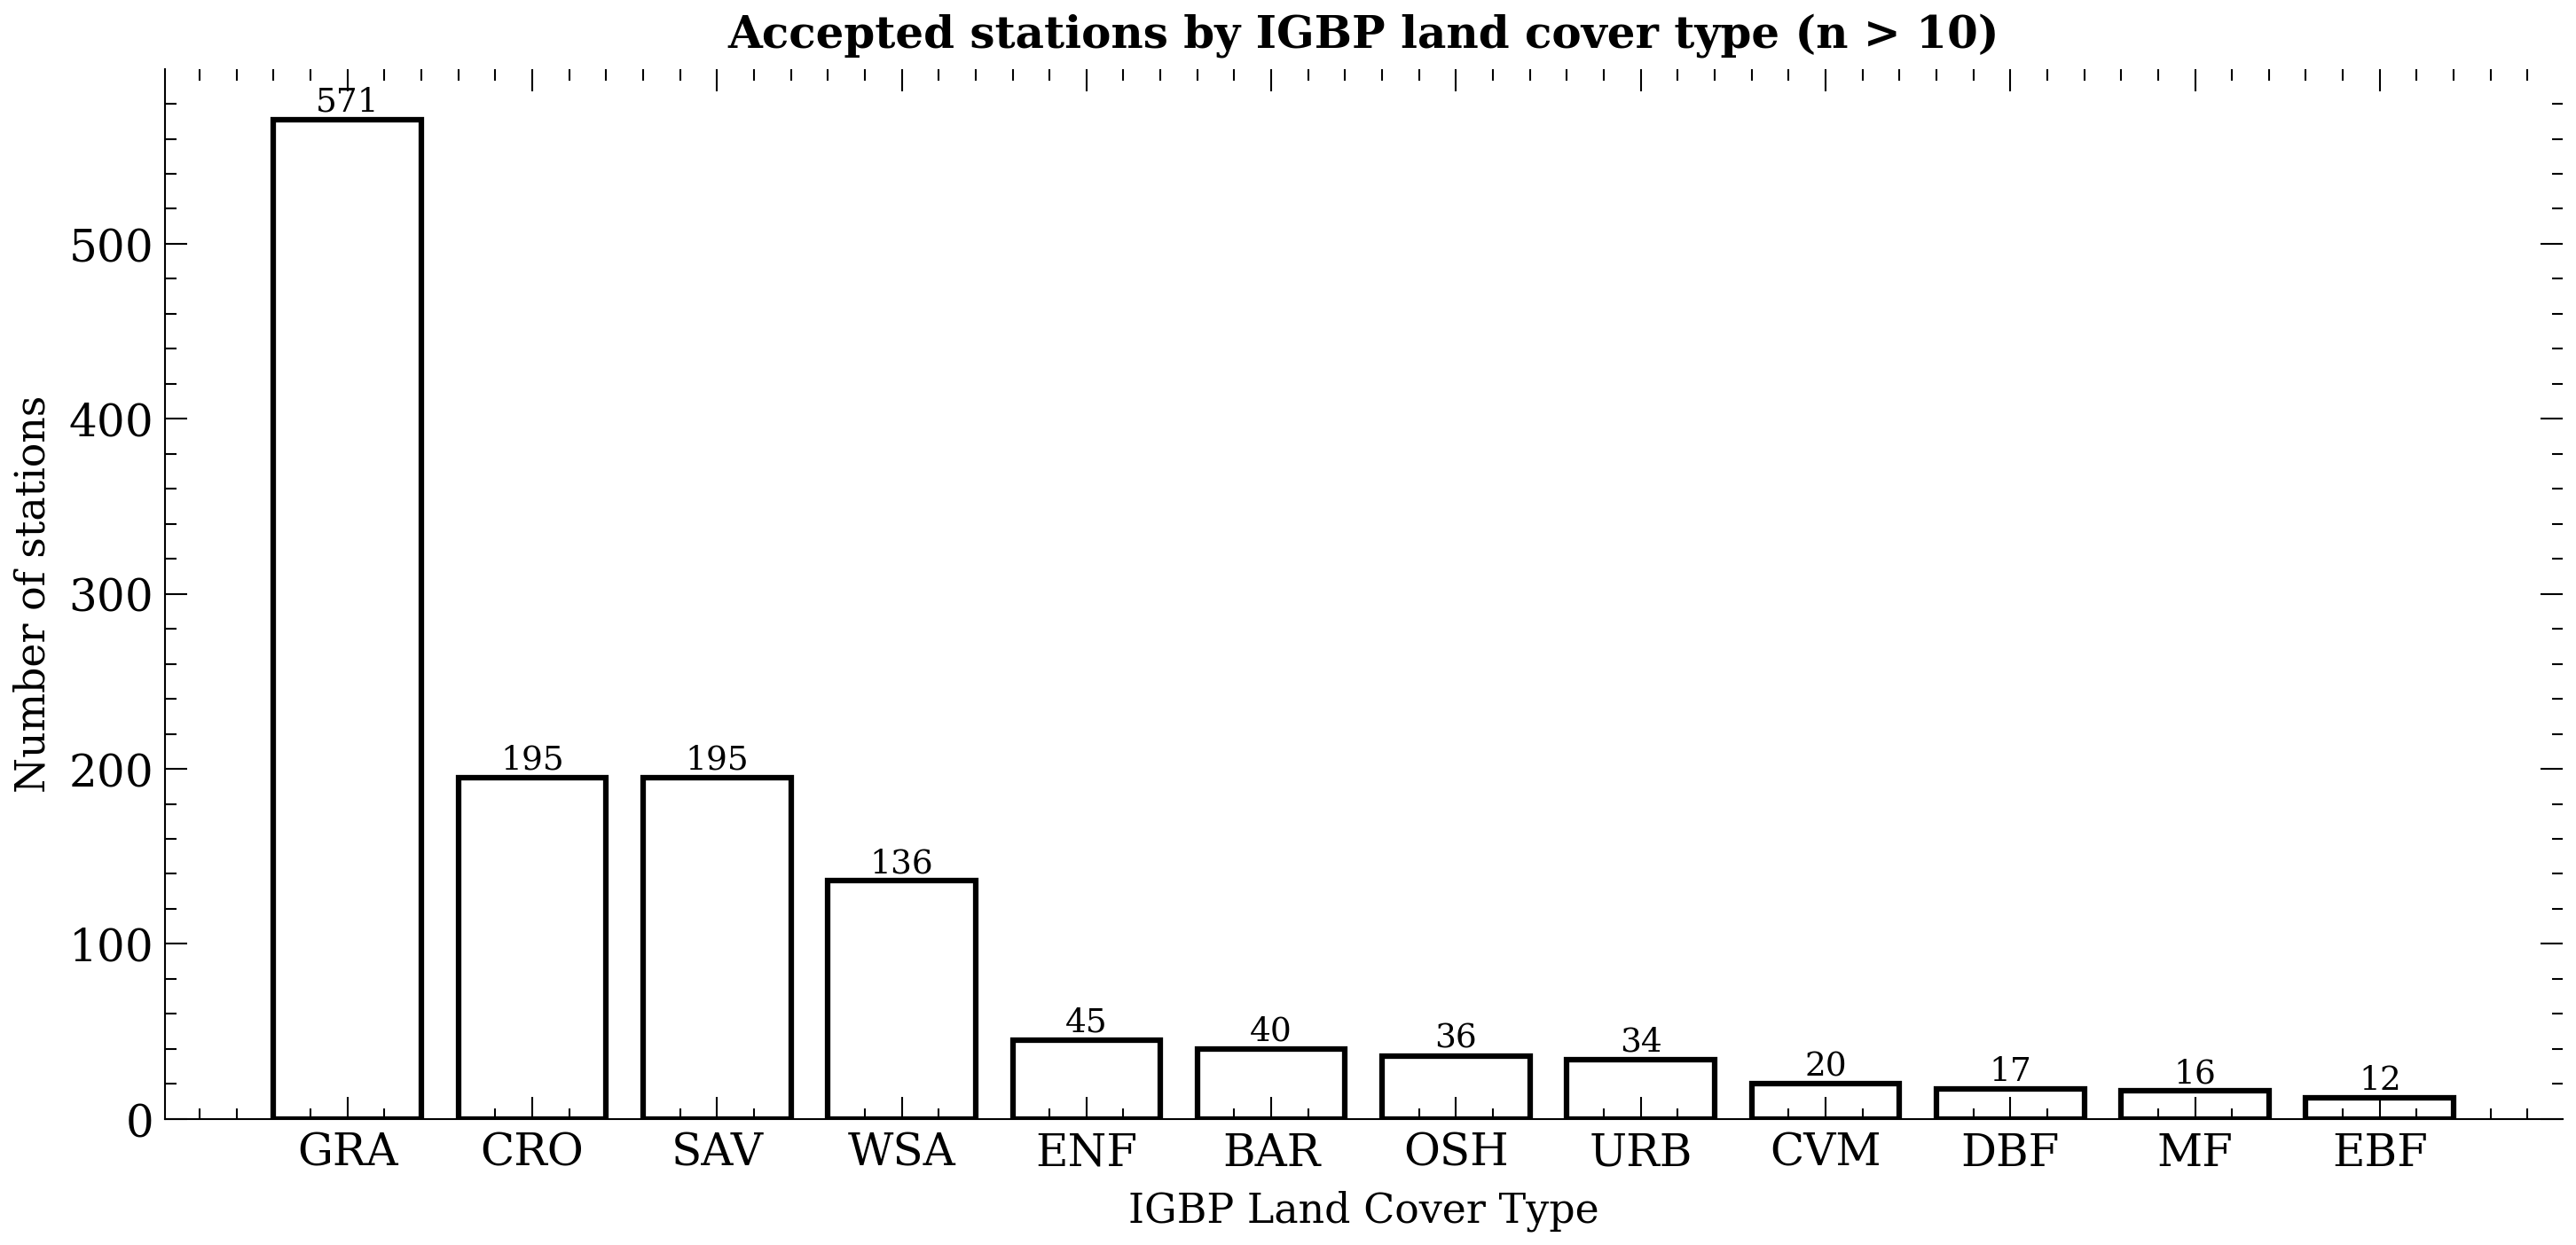

In [79]:
fig, ax = plt.subplots(figsize=(10, 5))

plot_data = counts[counts["n_stations"] > 10].sort_values("n_stations", ascending=False)

bars = ax.bar(plot_data["igbp_short"], plot_data["n_stations"],
              color="none", edgecolor="black", linewidth=1.5)

for bar, val in zip(bars, plot_data["n_stations"]):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,
            str(val), ha="center", va="bottom", fontsize=9, color="black")

ax.set_xlabel("IGBP Land Cover Type", fontsize=11)
ax.set_ylabel("Number of stations", fontsize=11)
ax.set_title("Accepted stations by IGBP land cover type (n > 10)", fontsize=12, fontweight="bold")
ax.spines[["top", "right"]].set_visible(False)

plt.tight_layout()
plt.savefig(f"{plot_output_path}stations_by_igbp.svg", format="svg", bbox_inches="tight")
plt.show()

In [80]:
depth_labels = ["0-10", "10-30", "30-50", ">50"]

saved = df_metadata[df_metadata["status"] == "saved"].copy()

# build a column for each depth
for depth in depth_labels:
    saved[depth] = saved["depths"].str.contains(depth, regex=False)

# group by igbp_short, sum each depth
depth_counts = (
    saved.groupby("igbp_short")[depth_labels]
    .sum()
    .astype(int)
)

# filter to land covers with > 10 stations (reuse counts from before)
valid_igbp = counts[counts["n_stations"] > 10]["igbp_short"]
depth_counts = depth_counts.loc[depth_counts.index.isin(valid_igbp)]
depth_counts = depth_counts.loc[counts[counts["n_stations"] > 10].set_index("igbp_short").index]  # preserve order

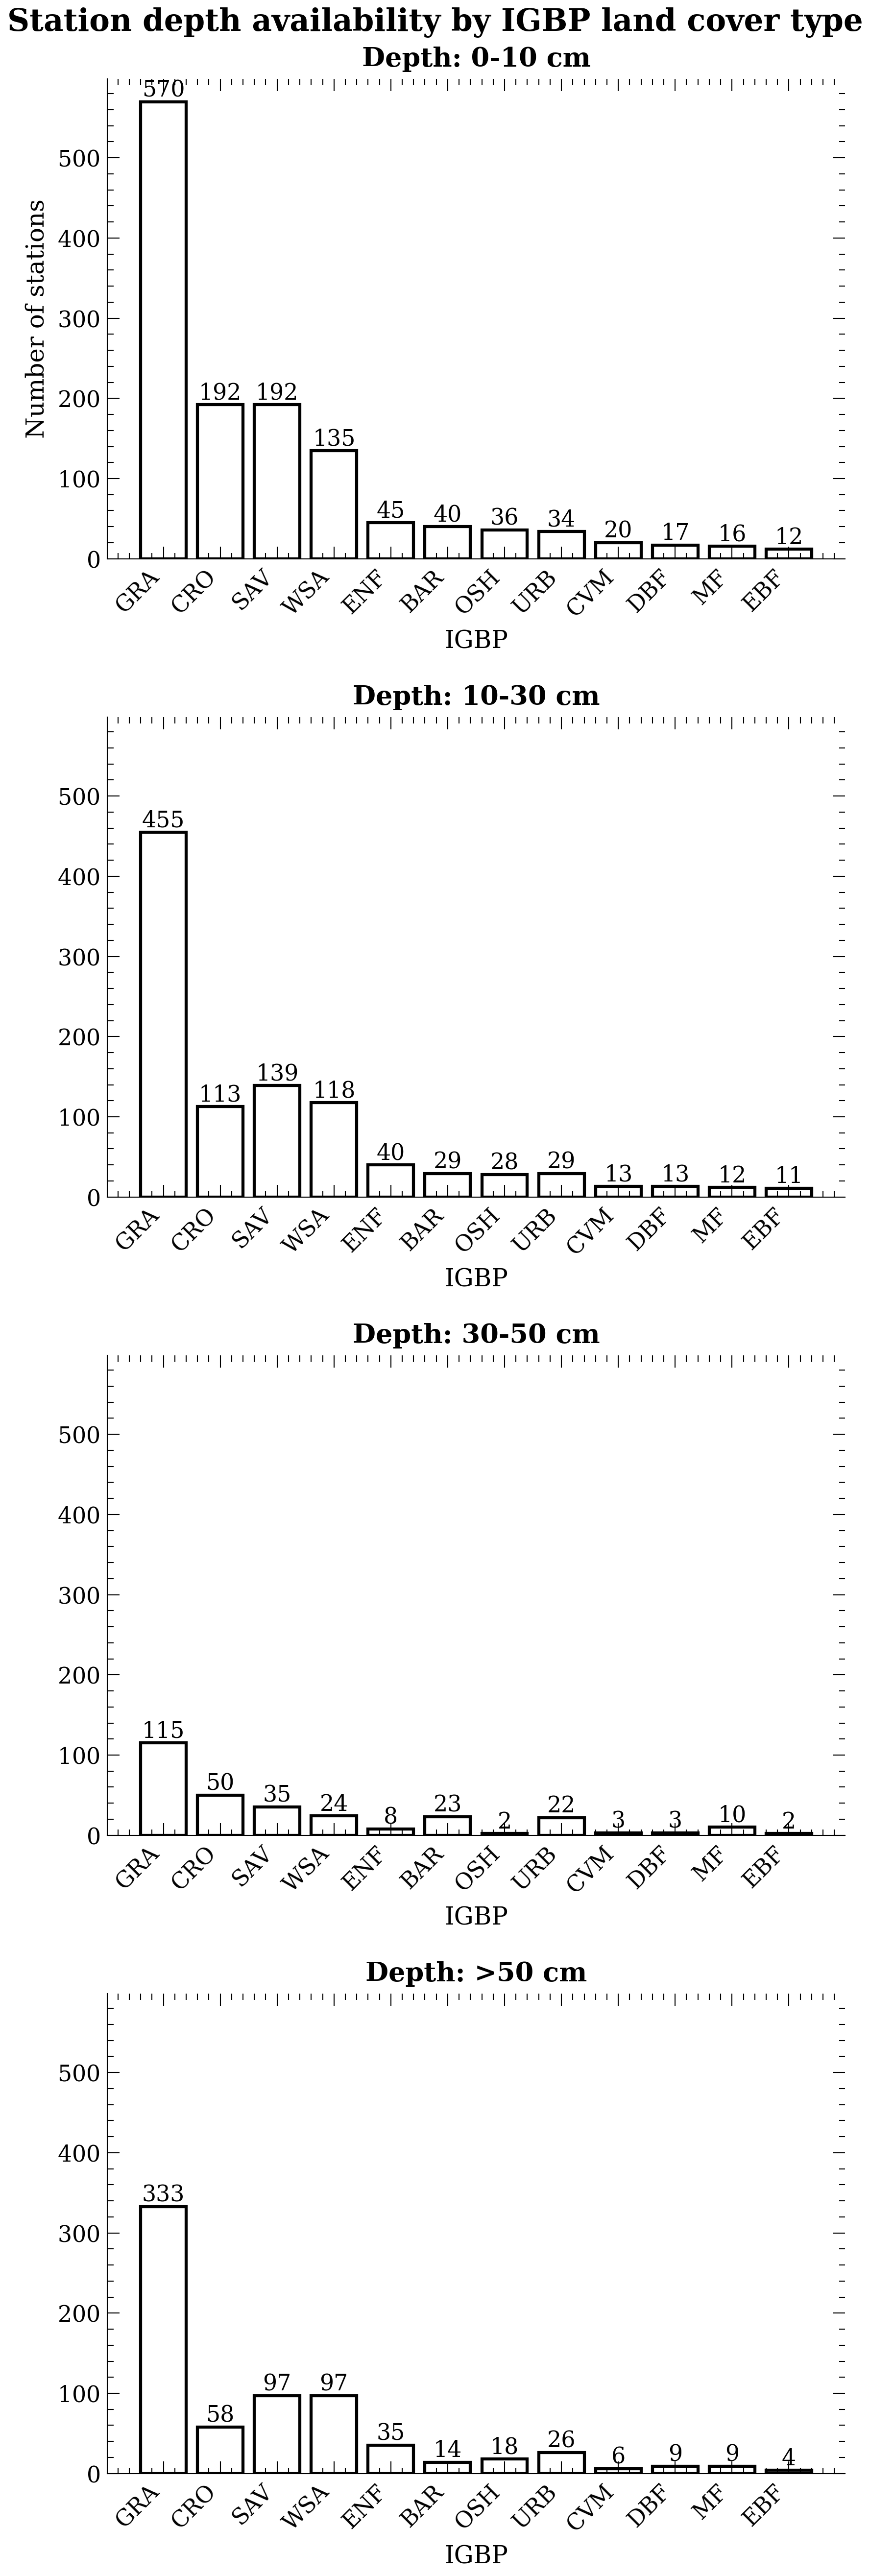

In [92]:
fig, axes = plt.subplots(4, 1, figsize=(6, 18), sharey=True)

for ax, depth in zip(axes, depth_labels):
    bars = ax.bar(depth_counts.index, depth_counts[depth],
                  color="none", edgecolor="black", linewidth=1.5)

    for bar, val in zip(bars, depth_counts[depth]):
        if val > 0:
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.3,
                    str(val), ha="center", va="bottom", fontsize=11, color="black")

    ax.set_title(f"Depth: {depth} cm", fontsize=13, fontweight="bold")
    ax.set_xlabel("IGBP", fontsize=12)
    ax.set_xticks(range(len(depth_counts.index)))
    ax.set_xticklabels(depth_counts.index, rotation=45, ha="right", fontsize=11)
    ax.tick_params(axis="y", labelsize=11)
    ax.spines[["top", "right"]].set_visible(False)

axes[0].set_ylabel("Number of stations", fontsize=12)

fig.suptitle("Station depth availability by IGBP land cover type",
             fontsize=15, fontweight="bold")

plt.tight_layout()
plt.savefig(f"{plot_output_path}stations_igbp_depth_subplots.svg", format="svg", bbox_inches="tight")
plt.show()

In [83]:
saved = df_metadata[df_metadata["status"] == "saved"].copy()
saved["start_date"] = pd.to_datetime(saved["start_date"], format="%Y%m%d")
saved["end_date"]   = pd.to_datetime(saved["end_date"],   format="%Y%m%d")


/home/khanalp/tmp/ipykernel_3272487/220403558.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(counts_year["igbp_short"], rotation=45, ha="right", fontsize=11)
/home/khanalp/tmp/ipykernel_3272487/220403558.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(counts_year["igbp_short"], rotation=45, ha="right", fontsize=11)
/home/khanalp/tmp/ipykernel_3272487/220403558.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(counts_year["igbp_short"], rotation=45, ha="right", fontsize=11)


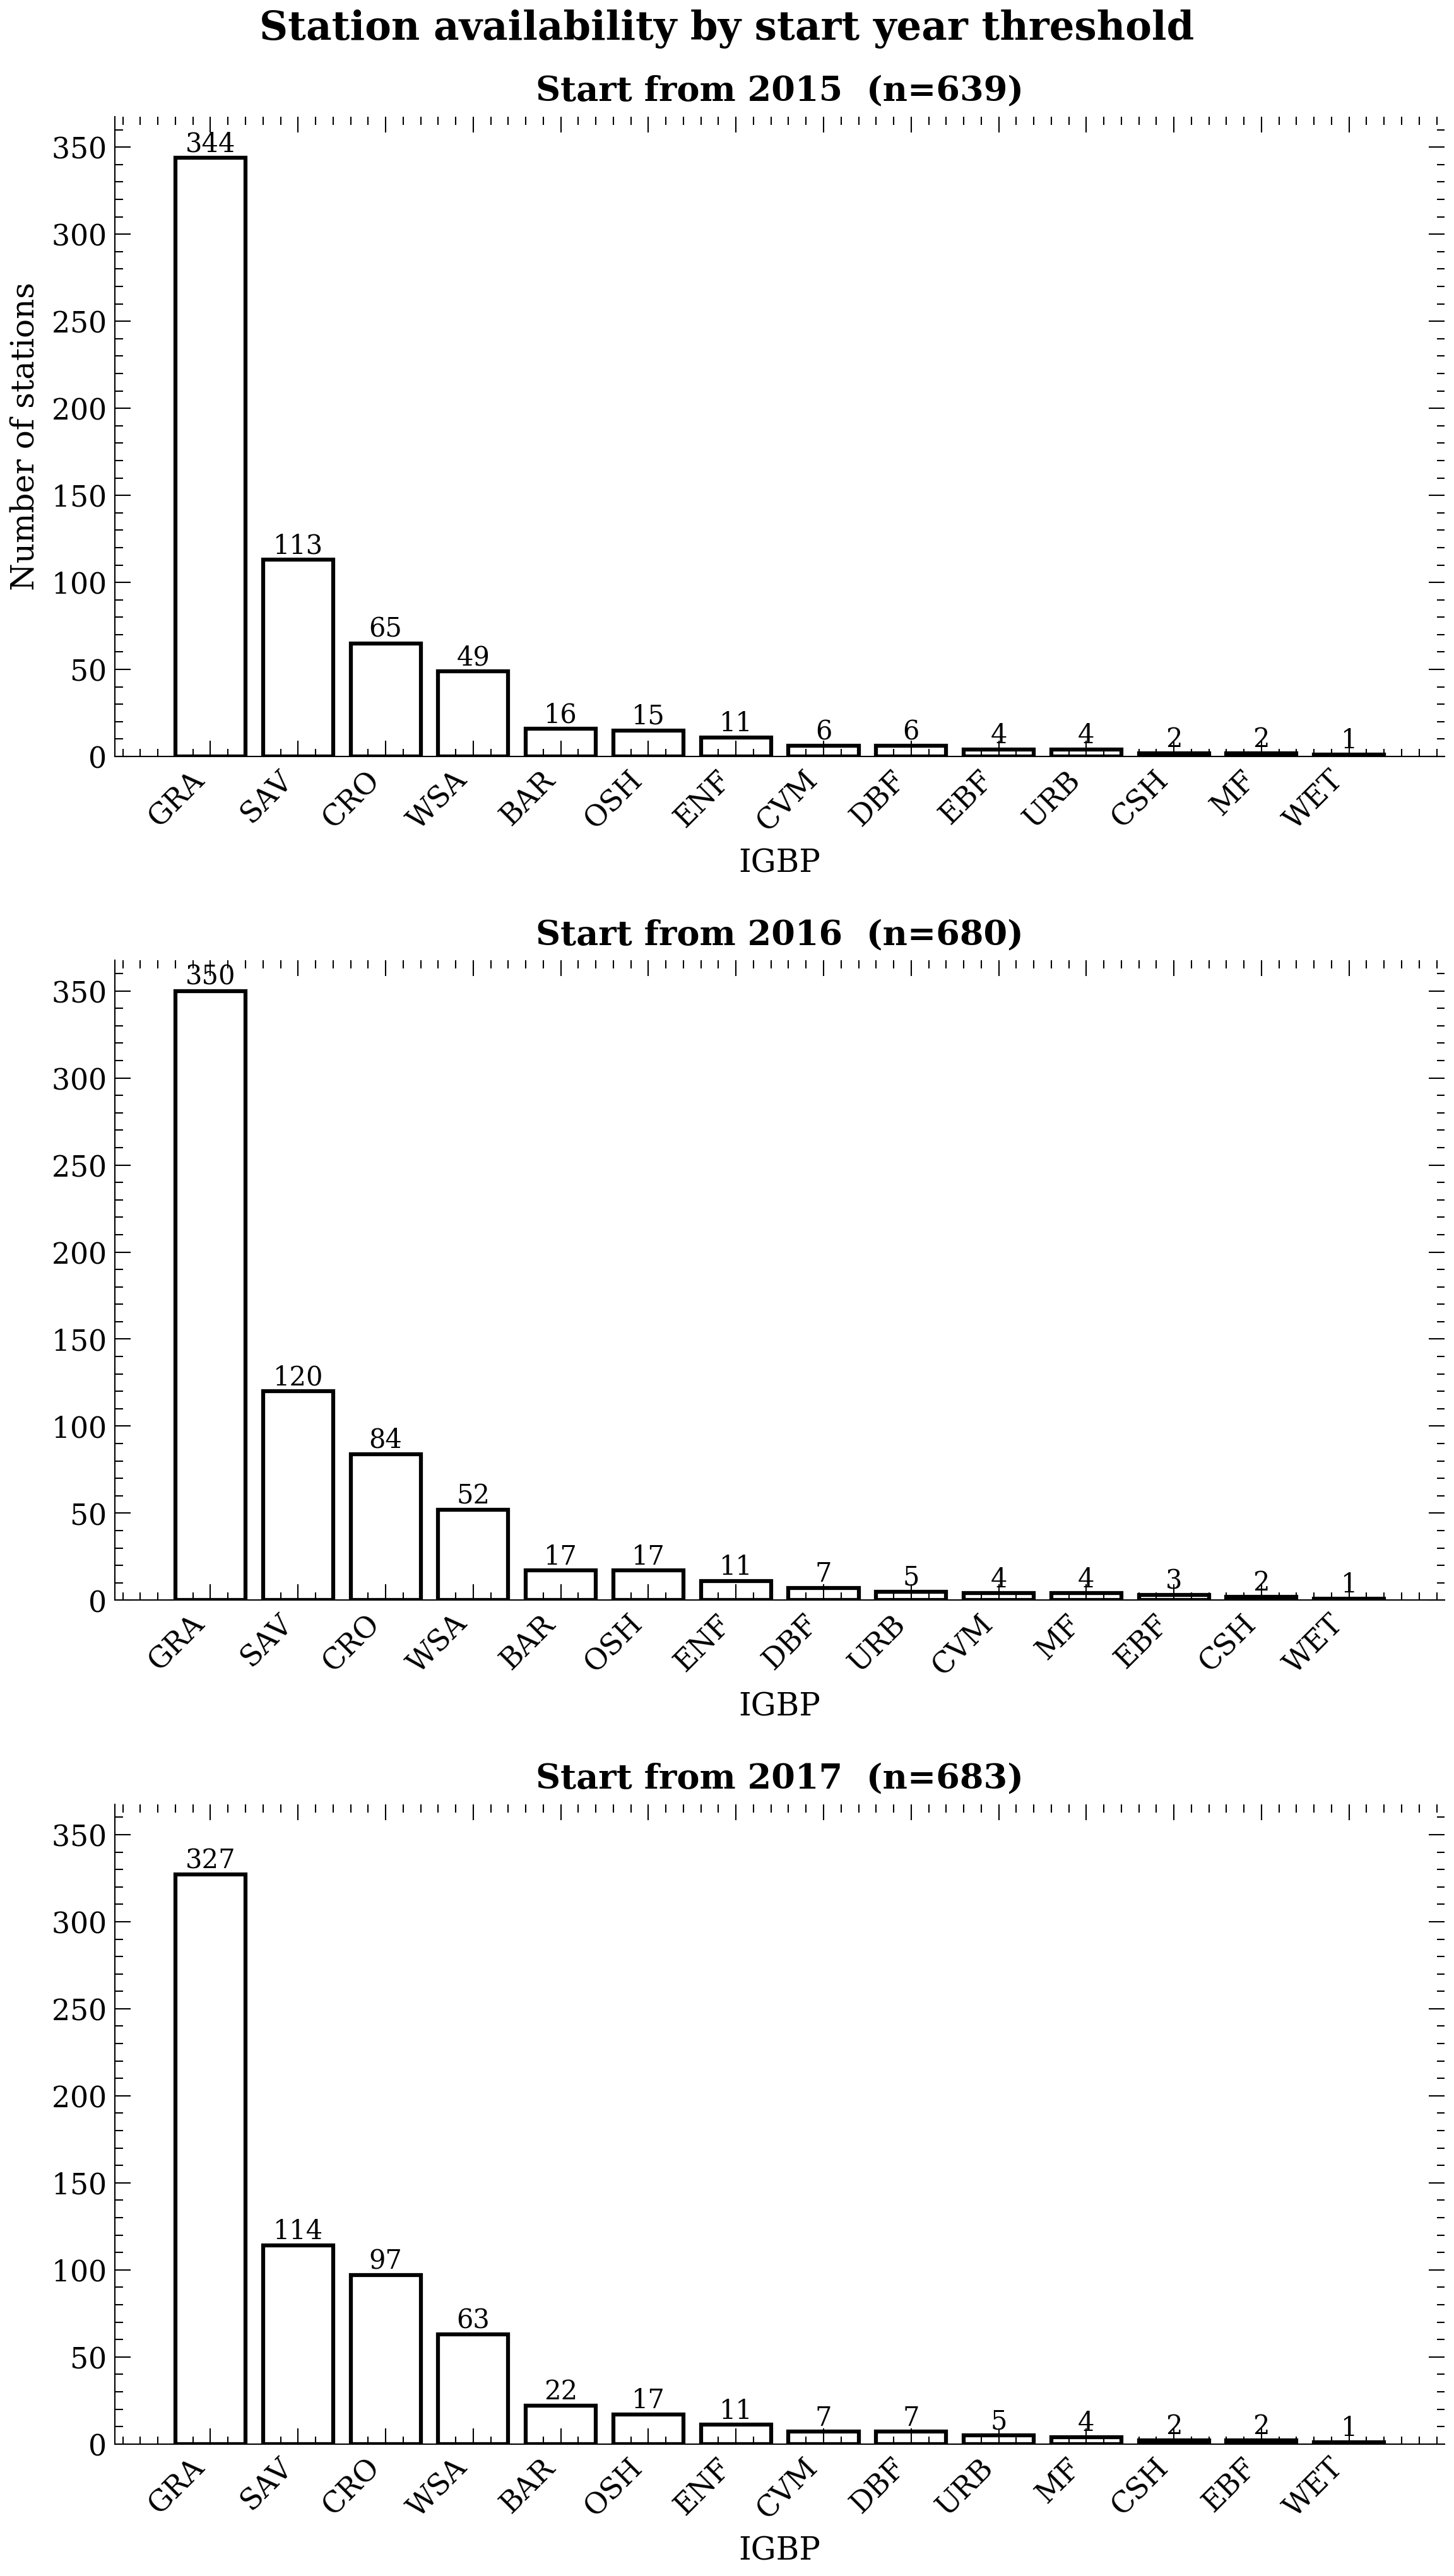

In [ ]:

threshold_years = [2015, 2016, 2017]

fig, axes = plt.subplots(3, 1, figsize=(8, 14), sharey=True)

for ax, year in zip(axes, threshold_years):
    cutoff = pd.Timestamp(f"{year}-01-01")

    # station must start on or before cutoff AND end after cutoff
    subset = saved[(saved["start_date"] <= cutoff) & (saved["end_date"] > cutoff)]

    counts_year = (
        subset.groupby("igbp_short")
        .size()
        .reset_index(name="n_stations")
        .sort_values("n_stations", ascending=False)
    )

    bars = ax.bar(counts_year["igbp_short"], counts_year["n_stations"],
                  color="none", edgecolor="black", linewidth=1.5)

    for bar, val in zip(bars, counts_year["n_stations"]):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.3,
                str(val), ha="center", va="bottom", fontsize=10, color="black")

    ax.set_title(f"Start from {year}  (n={len(subset)})", fontsize=13, fontweight="bold")
    ax.set_xlabel("IGBP", fontsize=12)
    ax.set_xticklabels(counts_year["igbp_short"], rotation=45, ha="right", fontsize=11)
    ax.tick_params(axis="y", labelsize=11)
    ax.spines[["top", "right"]].set_visible(False)

axes[0].set_ylabel("Number of stations", fontsize=12)

fig.suptitle("Station availability by start year threshold",
             fontsize=15, fontweight="bold")

plt.tight_layout()
plt.savefig(f"{plot_output_path}stations_by_start_year_landcover.svg", bbox_inches="tight")
plt.show()

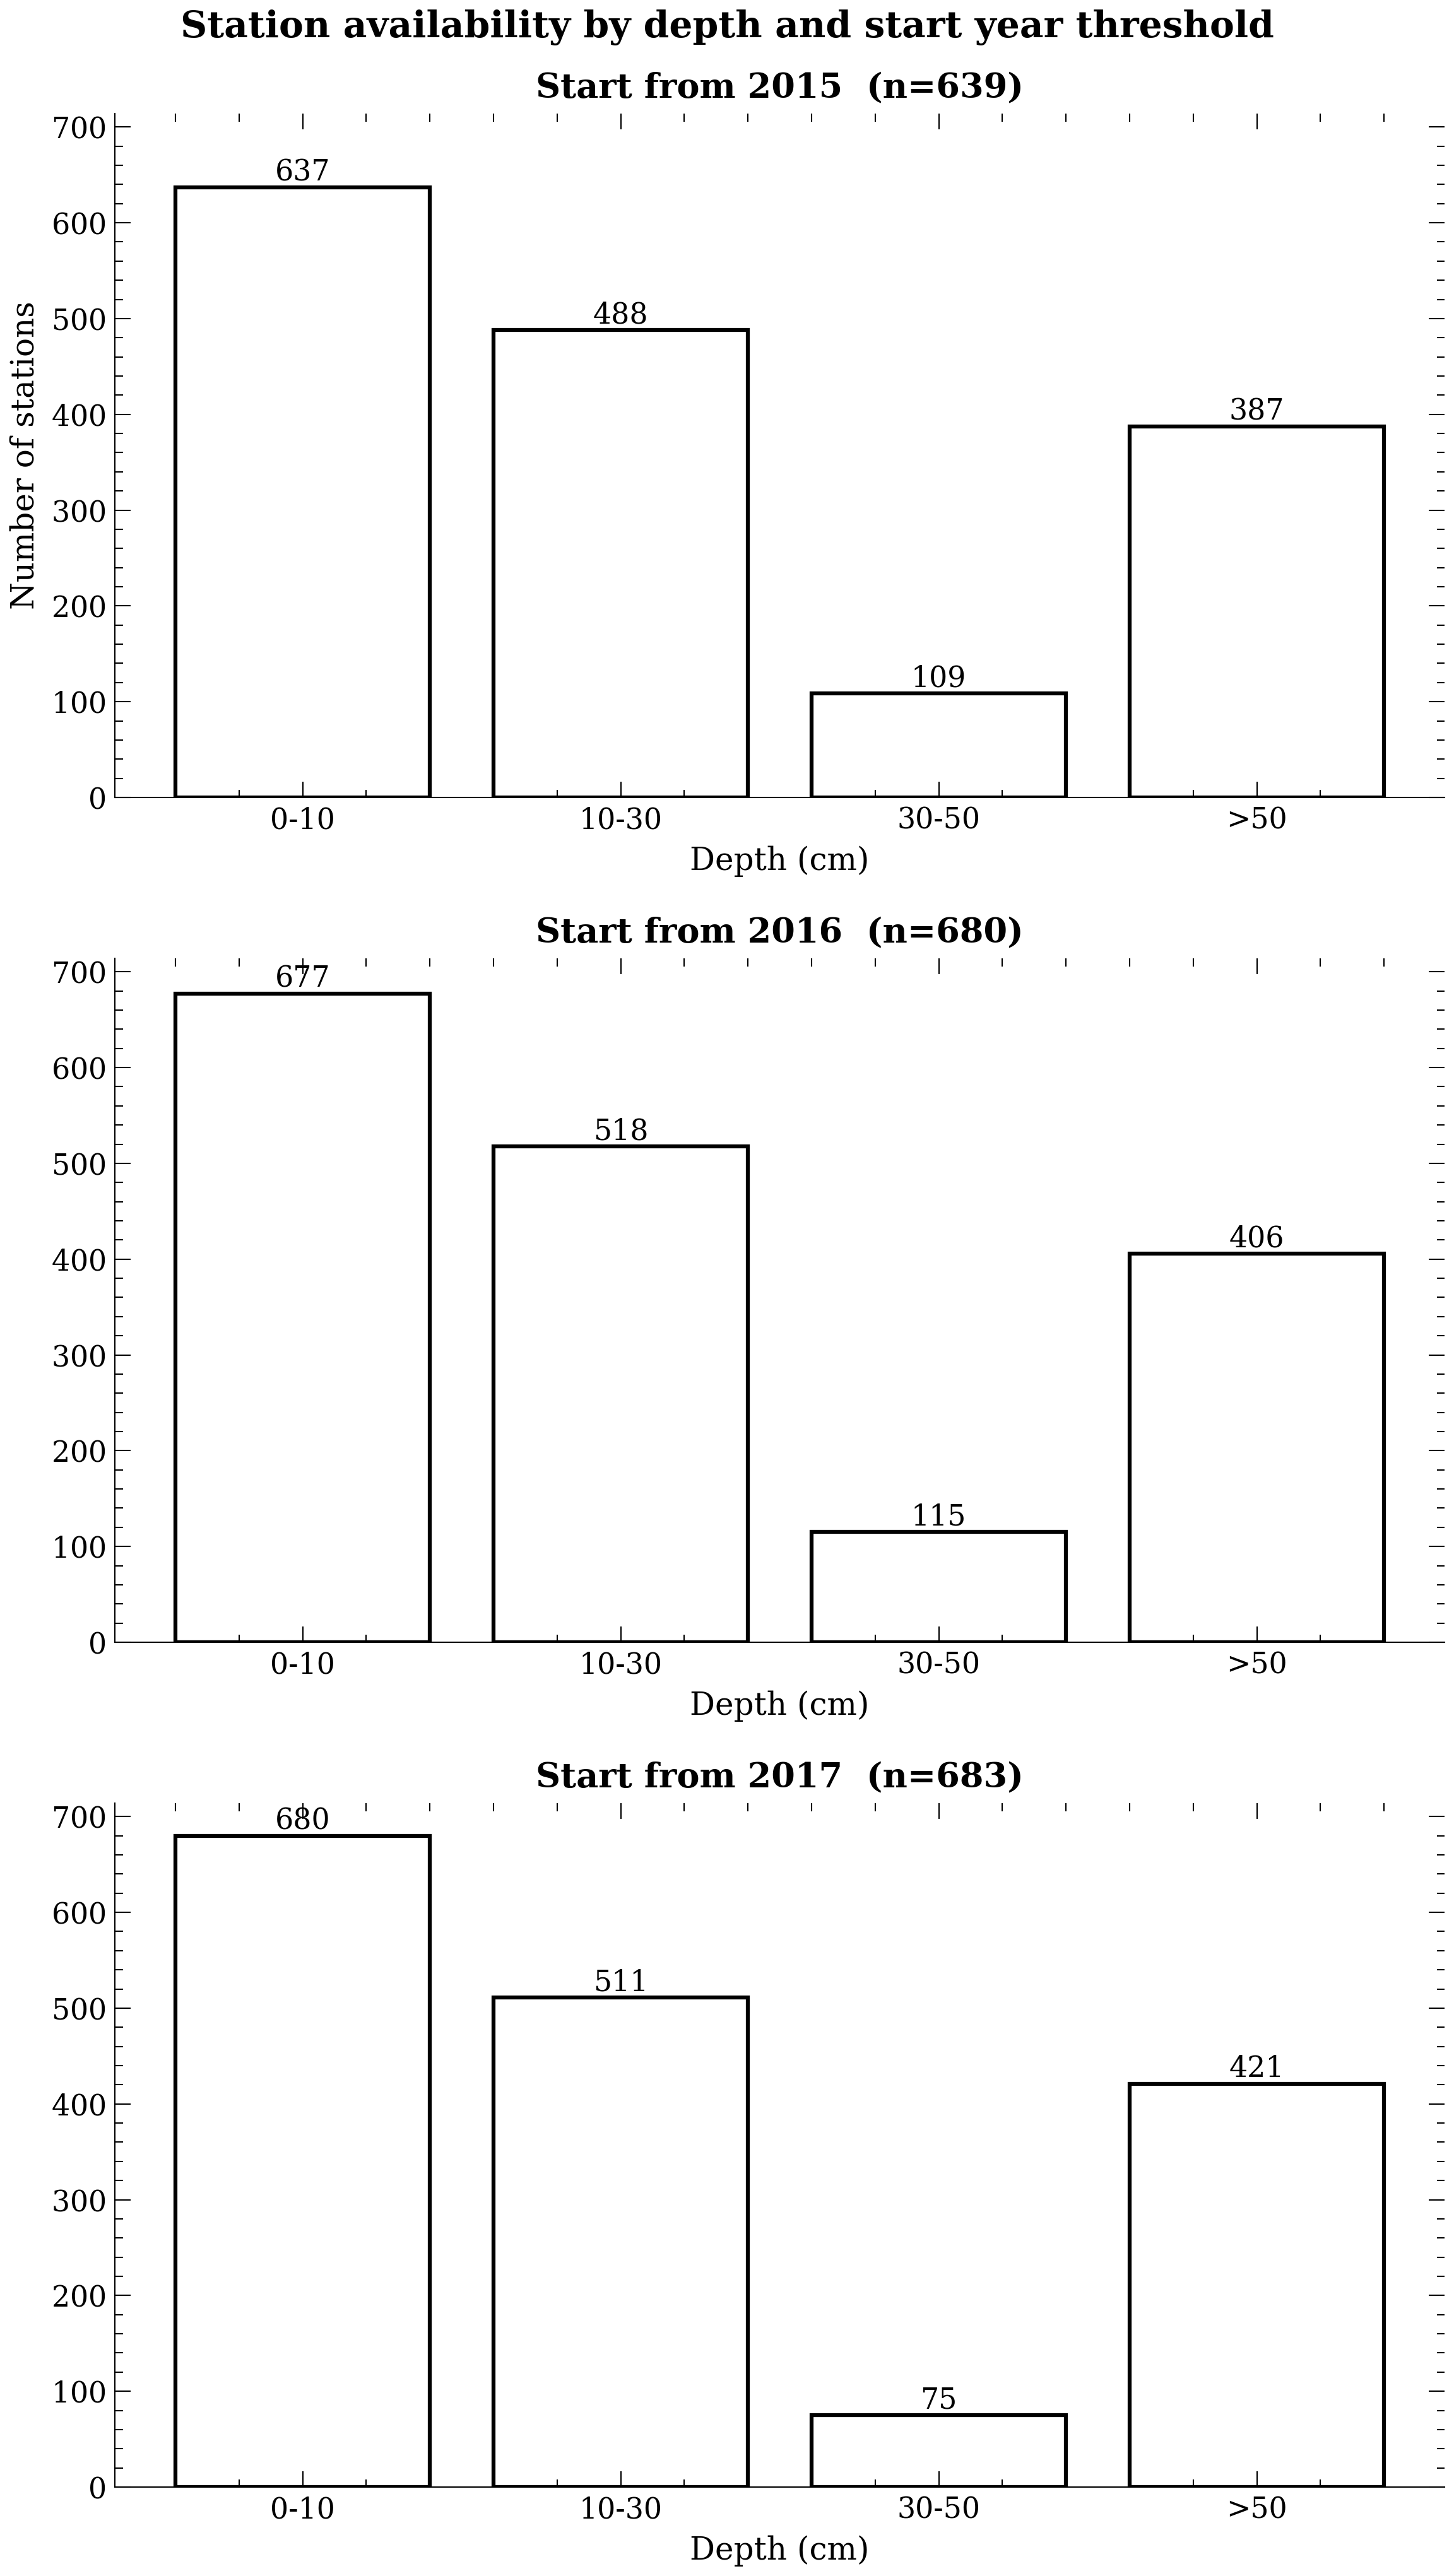

In [93]:
fig, axes = plt.subplots(3, 1, figsize=(8, 14), sharey=True)

for ax, year in zip(axes, threshold_years):
    cutoff = pd.Timestamp(f"{year}-01-01")
    subset = saved[(saved["start_date"] <= cutoff) & (saved["end_date"] > cutoff)]

    depth_counts_year = {
        depth: subset["depths"].str.contains(depth, regex=False).sum()
        for depth in depth_labels
    }

    bars = ax.bar(depth_counts_year.keys(), depth_counts_year.values(),
                  color="none", edgecolor="black", linewidth=1.5)

    for bar, val in zip(bars, depth_counts_year.values()):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.3,
                str(val), ha="center", va="bottom", fontsize=11, color="black")

    ax.set_title(f"Start from {year}  (n={len(subset)})", fontsize=13, fontweight="bold")
    ax.set_xlabel("Depth (cm)", fontsize=12)
    ax.tick_params(axis="both", labelsize=11)
    ax.spines[["top", "right"]].set_visible(False)

axes[0].set_ylabel("Number of stations", fontsize=12)

fig.suptitle("Station availability by depth and start year threshold",
             fontsize=14, fontweight="bold")

plt.tight_layout()
plt.savefig(f"{plot_output_path}stations_by_depth_year.svg", bbox_inches="tight")
plt.show()

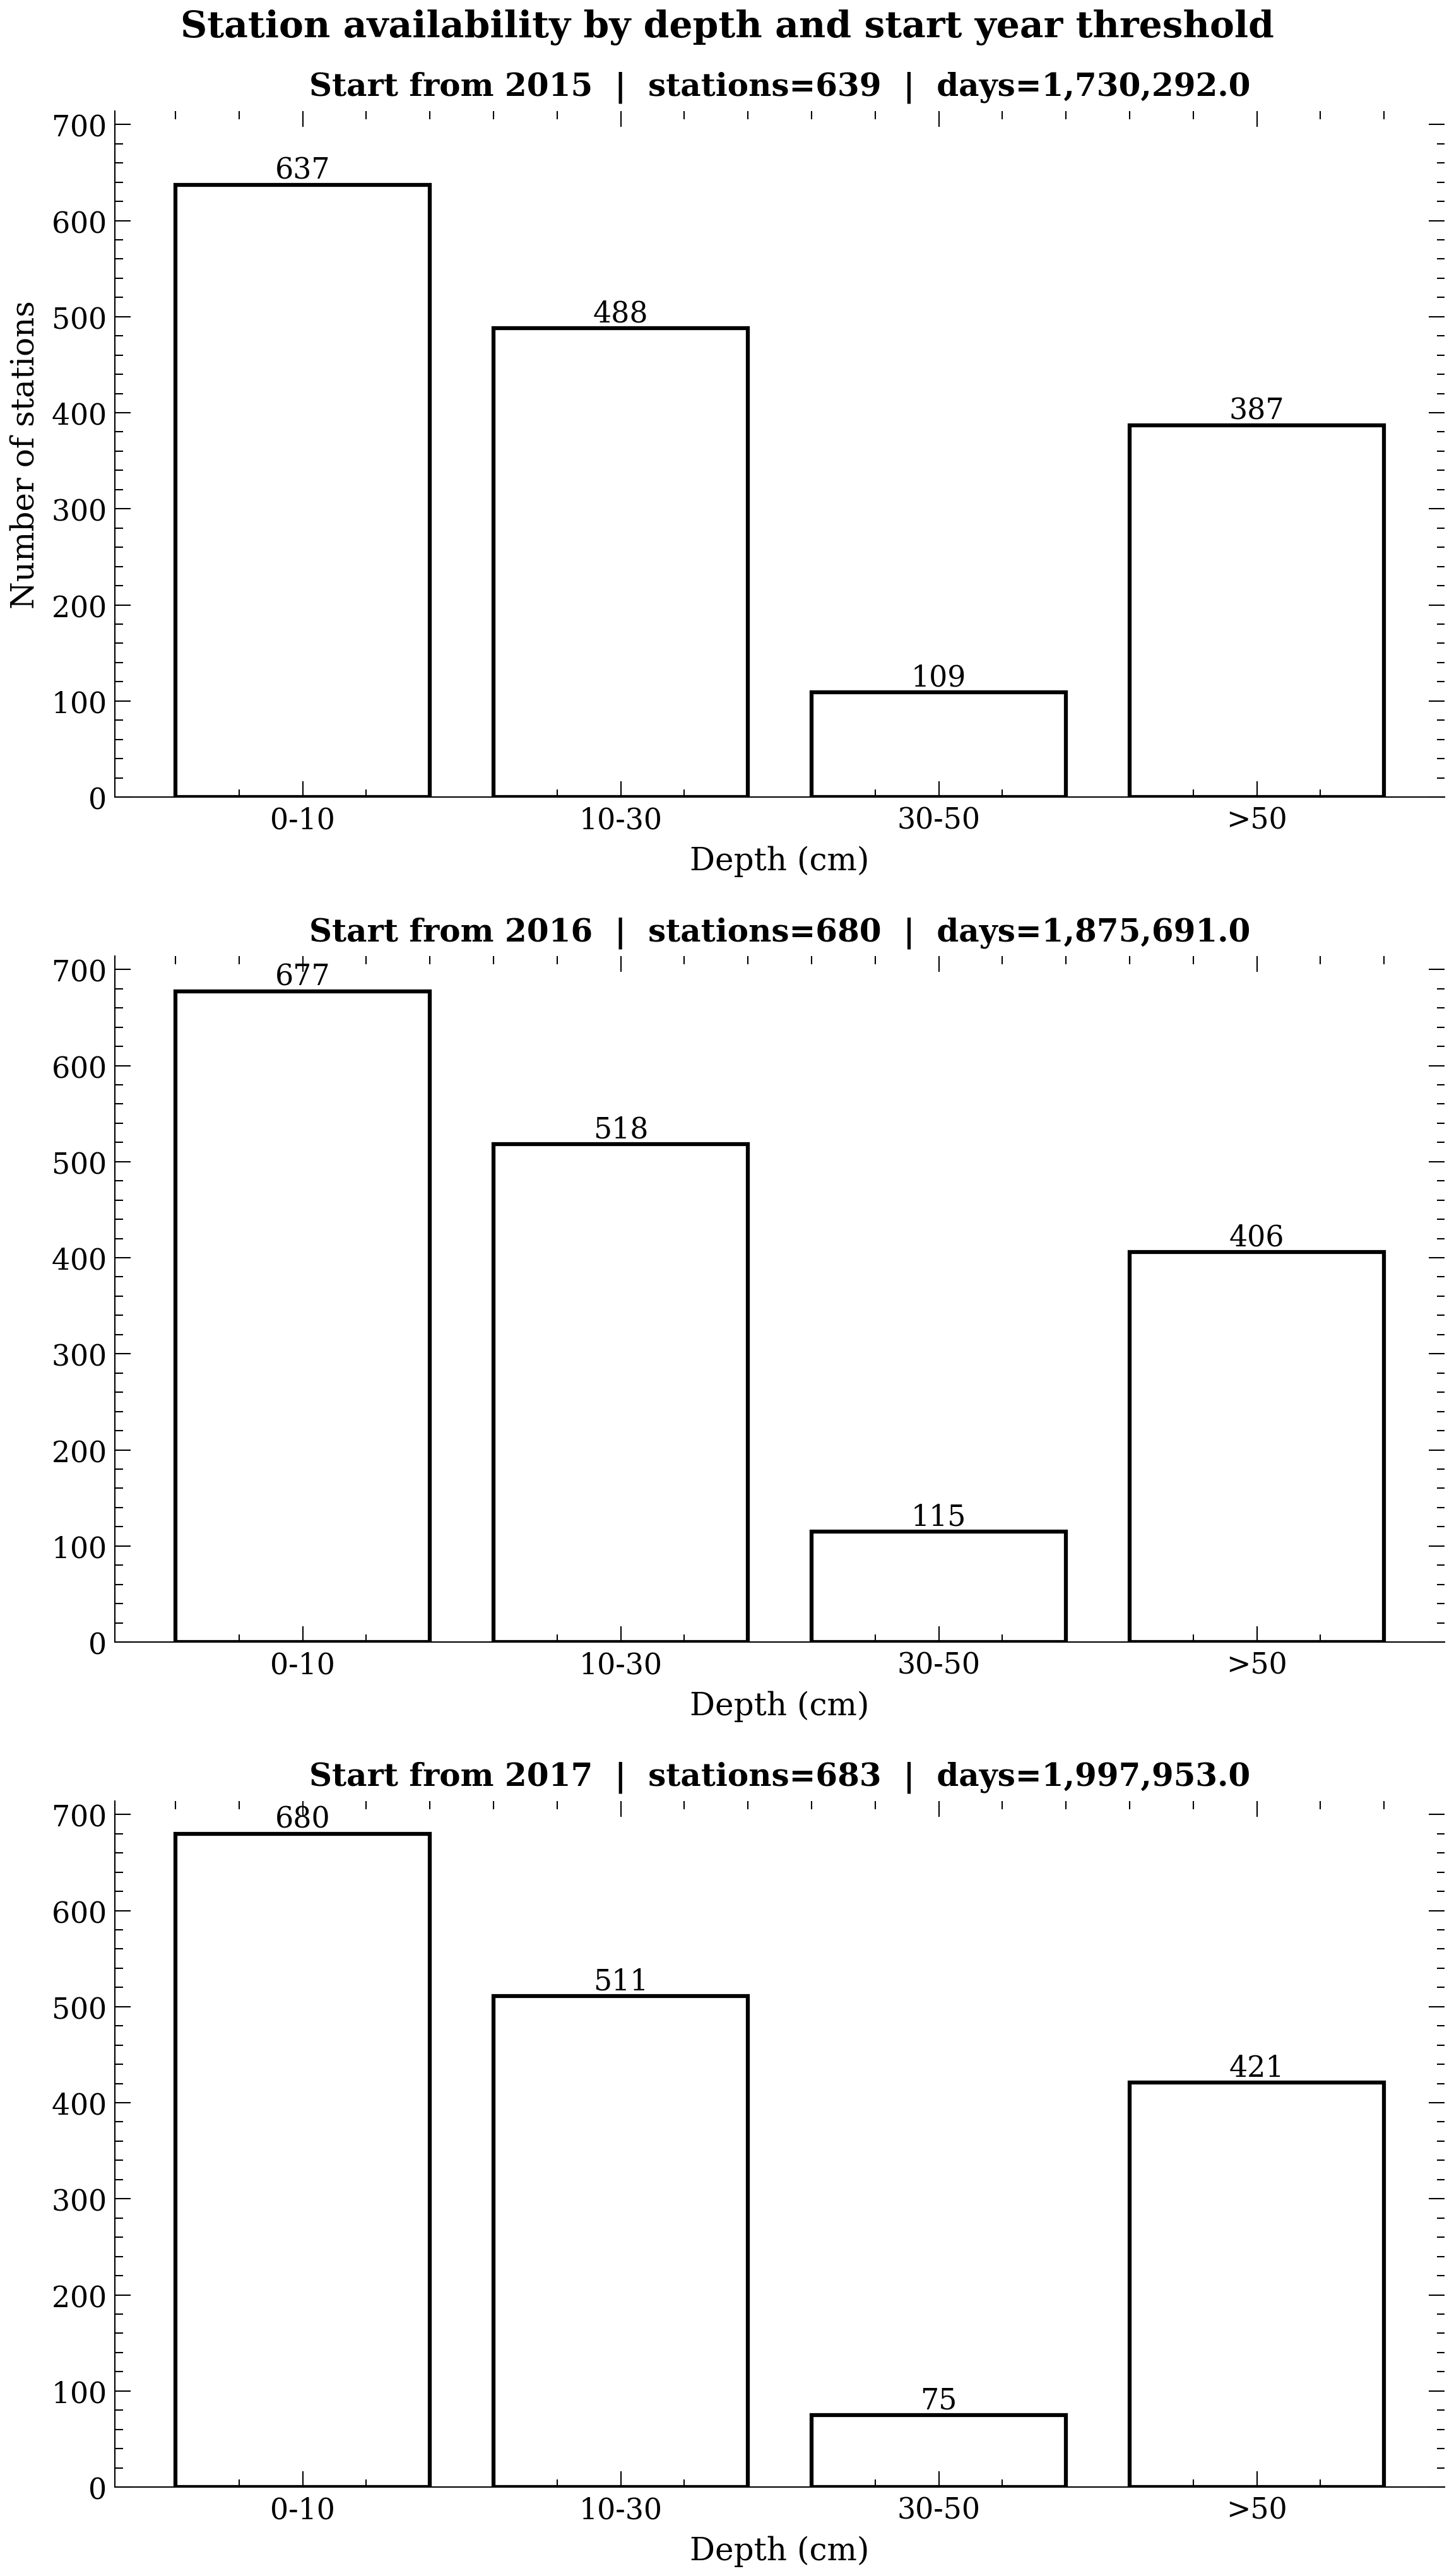

In [96]:
fig, axes = plt.subplots(3, 1, figsize=(8, 14), sharey=True)

for ax, year in zip(axes, threshold_years):
    cutoff = pd.Timestamp(f"{year}-01-01")
    subset = saved[(saved["start_date"] <= cutoff) & (saved["end_date"] > cutoff)]

    total_days = subset["n_days"].sum()

    depth_counts_year = {
        depth: subset["depths"].str.contains(depth, regex=False).sum()
        for depth in depth_labels
    }

    bars = ax.bar(depth_counts_year.keys(), depth_counts_year.values(),
                  color="none", edgecolor="black", linewidth=1.5)

    for bar, val in zip(bars, depth_counts_year.values()):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.3,
                str(val), ha="center", va="bottom", fontsize=11, color="black")

    ax.set_title(f"Start from {year}  |  stations={len(subset):,}  |  days={total_days:,}",
                 fontsize=12, fontweight="bold")
    ax.set_xlabel("Depth (cm)", fontsize=12)
    ax.tick_params(axis="both", labelsize=11)
    ax.spines[["top", "right"]].set_visible(False)

axes[0].set_ylabel("Number of stations", fontsize=12)

fig.suptitle("Station availability by depth and start year threshold",
             fontsize=14, fontweight="bold")

plt.tight_layout()
# plt.savefig("stations_by_depth_year.svg", bbox_inches="tight")
plt.show()

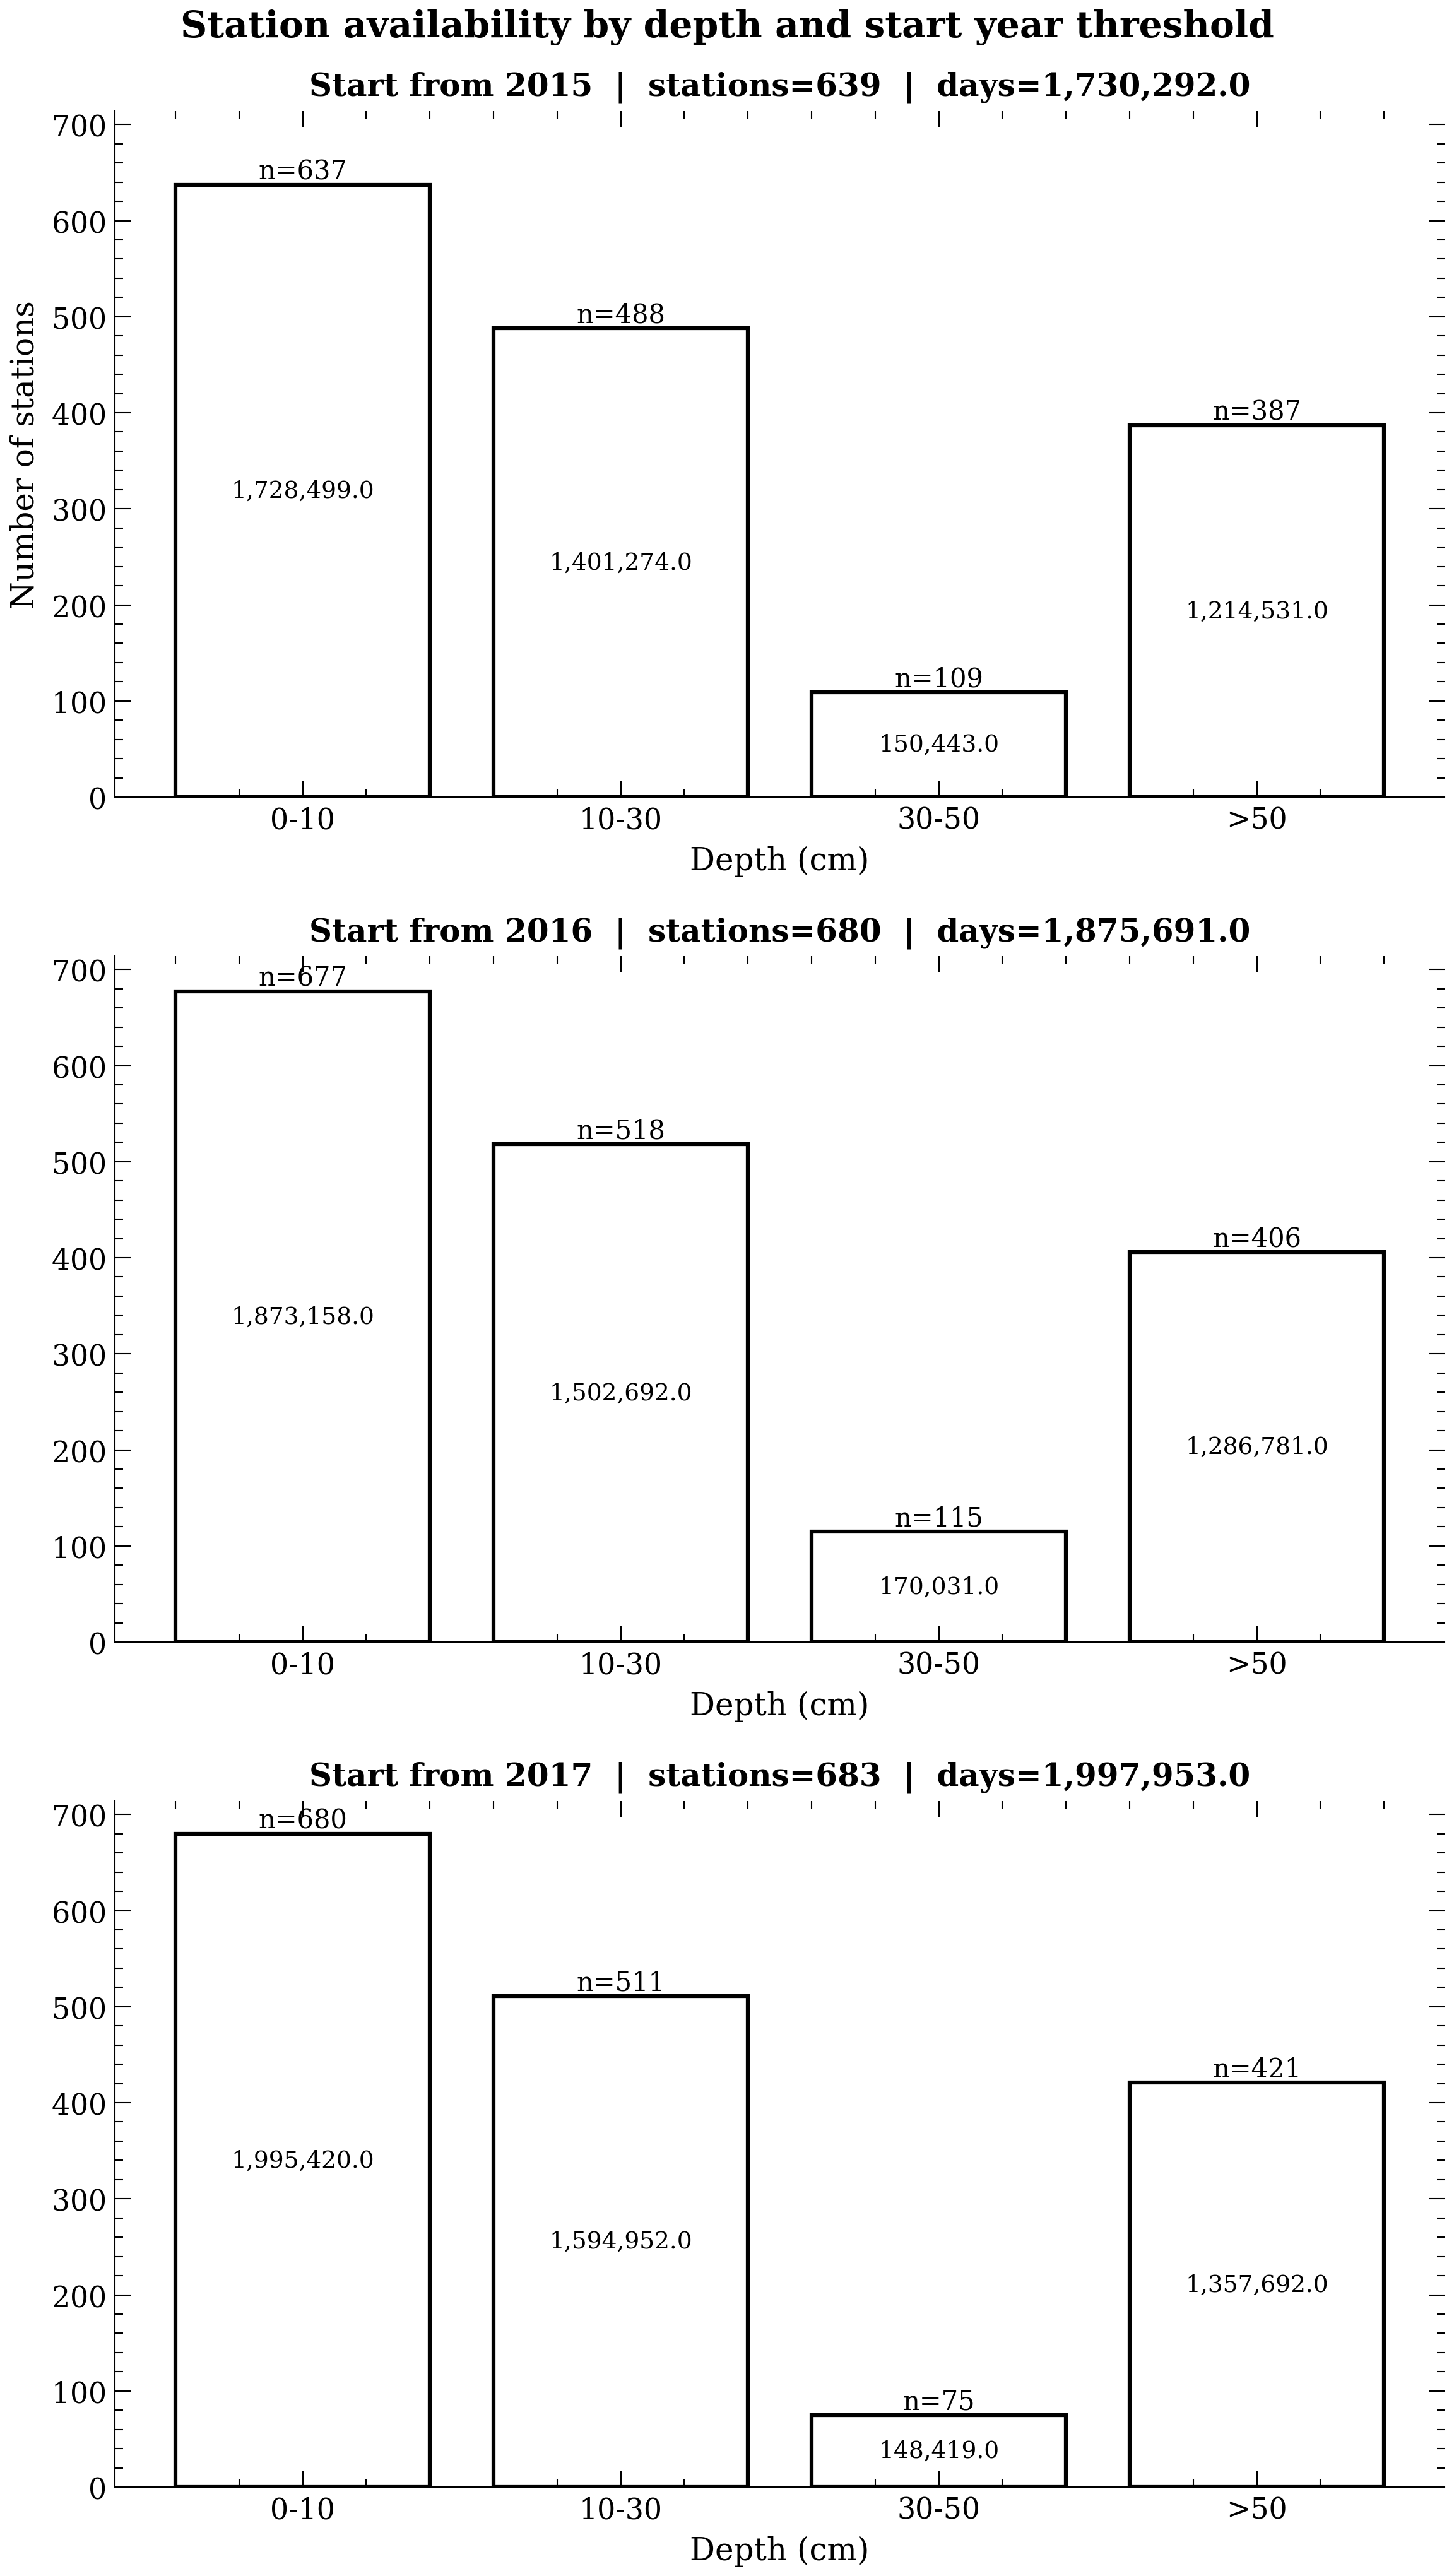

In [99]:
fig, axes = plt.subplots(3, 1, figsize=(8, 14), sharey=True)

for ax, year in zip(axes, threshold_years):
    cutoff = pd.Timestamp(f"{year}-01-01")
    subset = saved[(saved["start_date"] <= cutoff) & (saved["end_date"] > cutoff)]

    total_days = subset["n_days"].sum()

    depth_counts_year = {}
    depth_days_year   = {}
    for depth in depth_labels:
        mask = subset["depths"].str.contains(depth, regex=False)
        depth_counts_year[depth] = mask.sum()
        depth_days_year[depth]   = subset.loc[mask, "n_days"].sum()

    bars = ax.bar(depth_counts_year.keys(), depth_counts_year.values(),
                  color="none", edgecolor="black", linewidth=1.5)

    for bar, (depth, val) in zip(bars, depth_counts_year.items()):
        days = depth_days_year[depth]
        # stations count on top
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.3,
                f"n={val}", ha="center", va="bottom", fontsize=10, color="black")
        # days inside the bar
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2,
                f"{days:,}", ha="center", va="center", fontsize=9, color="black")

    ax.set_title(f"Start from {year}  |  stations={len(subset):,}  |  days={total_days:,}",
                 fontsize=12, fontweight="bold")
    ax.set_xlabel("Depth (cm)", fontsize=12)
    ax.tick_params(axis="both", labelsize=11)
    ax.spines[["top", "right"]].set_visible(False)

axes[0].set_ylabel("Number of stations", fontsize=12)

fig.suptitle("Station availability by depth and start year threshold",
             fontsize=14, fontweight="bold")

plt.tight_layout()
plt.savefig(f"{plot_output_path}stations_by_depth_year_datapoints.svg", bbox_inches="tight")
plt.show()